# Predicción del riesgo de enfermedad cardíaca: Tarea de regresión logística

## Contexto introductorio
Las enfermedades cardíacas son la principal causa de muerte en el mundo, cobrándose aproximadamente 18 millones de vidas al año, según la Organización Mundial de la Salud. Modelos predictivos como la regresión logística permiten la identificación temprana de pacientes en riesgo mediante el análisis de características clínicas como la edad, el colesterol y la presión arterial. Esto no solo mejora los resultados del tratamiento, sino que también optimiza la asignación de recursos en los entornos sanitarios. En esta tarea, implementarás la regresión logística en el conjunto de datos de enfermedades cardíacas: una colección de repositorios UCI del mundo real con 303 registros de pacientes, 14 características y un objetivo binario (1 para presencia de enfermedad, 0 para ausencia). Entrenarás modelos, visualizarás límites, aplicarás regularización y explorarás la implementación mediante Amazon SageMaker para simular un pipeline de producción.

Importar librerias

In [112]:
%pip install numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Crear directorio para reportes si no existe
os.makedirs('Reportes Generados', exist_ok=True)

## PASO 1: Cargar, Explorar y Preparar Datos

In [114]:
# Cargar el archivo CSV
df = pd.read_csv("Heart_Disease_Prediction.csv")

# Ver las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())
print("\n" + "="*80 + "\n")

# Información sobre el dataset
print("Información del dataset:")
print(df.info())
print("\n" + "="*80 + "\n")

# Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Ver la columna de destino ANTES de binarizar
print("Valores únicos en 'Heart Disease' (ANTES de binarizar):")
print(df['Heart Disease'].value_counts())
print(f"\nValores exactos: {df['Heart Disease'].unique()}")
print("\n" + "="*80 + "\n")

# Binarizar la columna de destino
# Convertir valores a string y hacer case-insensitive
df['Heart Disease'] = df['Heart Disease'].astype(str).str.strip().str.lower()
df['Heart Disease'] = (df['Heart Disease'] == 'presence').astype(int)

print("Después de binarizar:")
print(df['Heart Disease'].value_counts())
print(f"Proporción: {(df['Heart Disease'].value_counts() / len(df) * 100).round(2)}")
print("\nPrimeras filas después de binarizar:")
print(df.head())
print("\n" + "="*80 + "\n")

# Definir características numéricas (todas excepto el target)
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
if 'Heart Disease' in numeric_features:
    numeric_features.remove('Heart Disease')
print(f"Características numéricas identificadas: {numeric_features}")

Primeras 5 filas del dataset:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  

In [115]:
# VERIFICAR DATOS FALTANTES
print("=" * 80)
print("2. ANÁLISIS DE DATOS FALTANTES")
print("=" * 80)
missing_data = df.isnull().sum()
print("\nDatos faltantes por columna:")
print(missing_data)
print(f"\nTotal de datos faltantes en el dataset: {missing_data.sum()}")

if missing_data.sum() == 0:
    print("✓ ¡Excelente! No hay datos faltantes en el dataset.")
else:
    print("\nColumnas con datos faltantes:")
    print(missing_data[missing_data > 0])
    # Rellenar con la media para numéricas
    df = df.fillna(df.mean(numeric_only=True))
    print("Datos faltantes rellenados con la media.")

2. ANÁLISIS DE DATOS FALTANTES

Datos faltantes por columna:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Total de datos faltantes en el dataset: 0
✓ ¡Excelente! No hay datos faltantes en el dataset.



3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)

Recuento de clases:
  Clase 0 (Sin enfermedad): 150 muestras (55.56%)
  Clase 1 (Presencia de enfermedad): 120 muestras (44.44%)

Ratio de clases (mayoritaria/minoritaria): 1.25
✓ Dataset relativamente equilibrado.


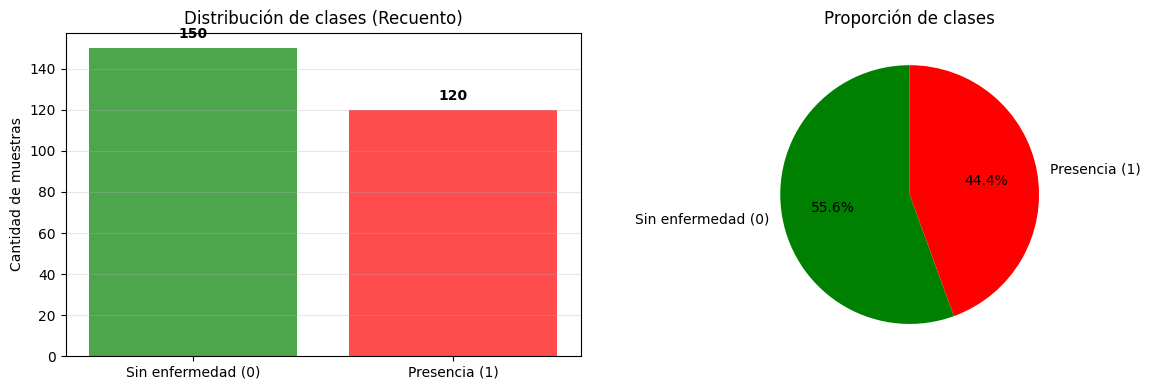


✓ Visualización de distribución completada.


In [116]:
# DISTRIBUCIÓN DE CLASES (TARGET)
print("\n" + "=" * 80)
print("3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)")
print("=" * 80)

class_counts = df['Heart Disease'].value_counts()
class_proportions = df['Heart Disease'].value_counts(normalize=True) * 100

print("\nRecuento de clases:")
for idx in sorted(df['Heart Disease'].unique()):
    label = "Presencia de enfermedad" if idx == 1 else "Sin enfermedad"
    count = class_counts[idx]
    percentage = class_proportions[idx]
    print(f"  Clase {idx} ({label}): {count} muestras ({percentage:.2f}%)")

# Verificar balance de clases
class_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de clases (mayoritaria/minoritaria): {class_ratio:.2f}")

# Comprobar balance de forma segura
if len(class_proportions) == 2:
    if abs(class_proportions.iloc[0] - class_proportions.iloc[1]) > 20:
        print("⚠ ADVERTENCIA: Dataset DESBALANCEADO. Considerar técnicas de balanceo.")
    else:
        print("✓ Dataset relativamente equilibrado.")
else:
    print(f"⚠ ADVERTENCIA: Solo se encontró 1 clase. Dataset muy desbalanceado.")

# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras - usar solo las clases que existen
class_labels_actual = [("Sin enfermedad (0)" if idx == 0 else "Presencia (1)") for idx in class_counts.index]
colors_actual = ['green' if idx == 0 else 'red' for idx in class_counts.index]

axes[0].bar(class_labels_actual, class_counts.values, color=colors_actual, alpha=0.7)
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_title('Distribución de clases (Recuento)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel - usar solo las clases que existen
axes[1].pie(class_counts.values, labels=class_labels_actual, autopct='%1.1f%%', 
            colors=colors_actual, startangle=90)
axes[1].set_title('Proporción de clases')

plt.tight_layout()
plt.show()

print("\n✓ Visualización de distribución completada.")

In [117]:
# ESTADÍSTICAS POR CLASE
print("\n" + "=" * 80)
print("4. ESTADÍSTICAS POR CLASE")
print("=" * 80)

print("\nEstadísticas para pacientes SIN enfermedad (clase 0):")
print(df[df['Heart Disease'] == 0].describe())

print("\n" + "-" * 80 + "\n")
print("Estadísticas para pacientes CON enfermedad (clase 1):")
print(df[df['Heart Disease'] == 1].describe())


4. ESTADÍSTICAS POR CLASE

Estadísticas para pacientes SIN enfermedad (clase 0):
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  150.000000  150.000000       150.000000  150.000000   150.000000   
mean    52.706667    0.553333         2.820000  128.866667   244.213333   
std      9.509830    0.498813         0.927362   16.457660    54.019085   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     45.000000    0.000000         2.000000  120.000000   209.000000   
50%     52.000000    1.000000         3.000000  130.000000   236.000000   
75%     59.000000    1.000000         3.750000  140.000000   268.750000   
max     76.000000    1.000000         4.000000  180.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    150.000000   150.000000  150.000000       150.000000     150.000000   
mean       0.153333     0.860000  158.333333         0.153333       0.622667   
st

In [118]:
# ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)
print("\n" + "=" * 80)
print("5. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)")
print("=" * 80)

# Identificar características numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir la columna target
if 'Heart Disease' in numeric_cols:
    numeric_cols.remove('Heart Disease')

print(f"\nCaracterísticas numéricas analizadas: {len(numeric_cols)}")

# Detección de outliers usando IQR (Rango Intercuartílico)
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_summary[col] = len(outliers)

if outlier_summary:
    print(f"\nSe encontraron valores atípicos en {len(outlier_summary)} columnas:")
    for col, count in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {col}: {count} outliers")
else:
    print("\n✓ No se detectaron valores atípicos significativos en las características.")

# Mostrar resumen de outliers como porcentaje
total_rows = len(df)
print("\nPorcentaje de outliers por columna:")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    percentage = (outlier_count / total_rows) * 100
    if percentage > 0:
        print(f"  {col}: {percentage:.2f}%")


5. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)

Características numéricas analizadas: 13

Se encontraron valores atípicos en 7 columnas:
  - FBS over 120: 40 outliers
  - Chest pain type: 20 outliers
  - Number of vessels fluro: 19 outliers
  - BP: 9 outliers
  - Cholesterol: 5 outliers
  - ST depression: 4 outliers
  - Max HR: 1 outliers

Porcentaje de outliers por columna:
  Chest pain type: 7.41%
  BP: 3.33%
  Cholesterol: 1.85%
  FBS over 120: 14.81%
  Max HR: 0.37%
  ST depression: 1.48%
  Number of vessels fluro: 7.04%



6. DISTRIBUCIÓN DE CARACTERÍSTICAS


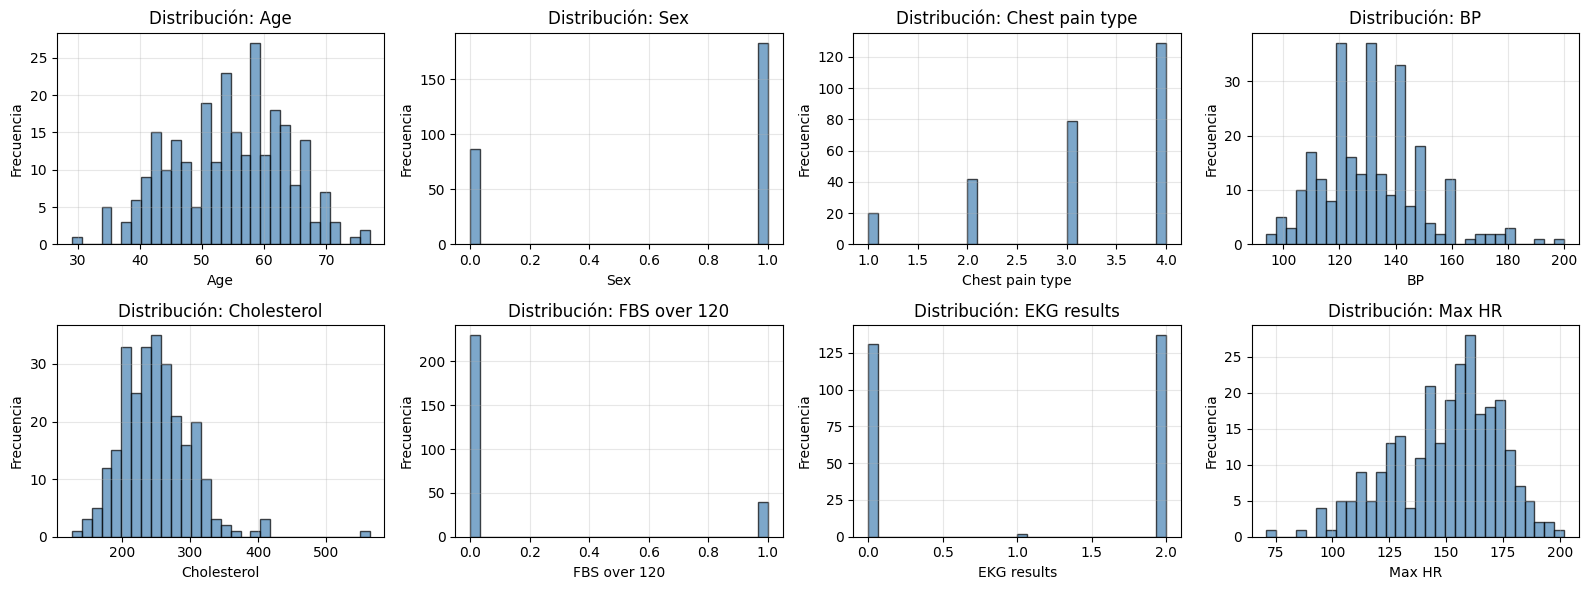


✓ Visualización de 8 características completada.


In [119]:
# VISUALIZACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA
print("\n" + "=" * 80)
print("6. DISTRIBUCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar algunas características clave para visualizar
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Heart Disease' in numeric_features:
    numeric_features.remove('Heart Disease')

# Visualizar histogramas y boxplots para primeras 8 características
features_to_plot = numeric_features[:min(8, len(numeric_features))]
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*3))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(df[feature], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribución: {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualización de {len(features_to_plot)} características completada.")


7. ANÁLISIS DE CORRELACIONES

Correlación de características con 'Heart Disease':
Heart Disease              1.000000
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease, dtype: float64


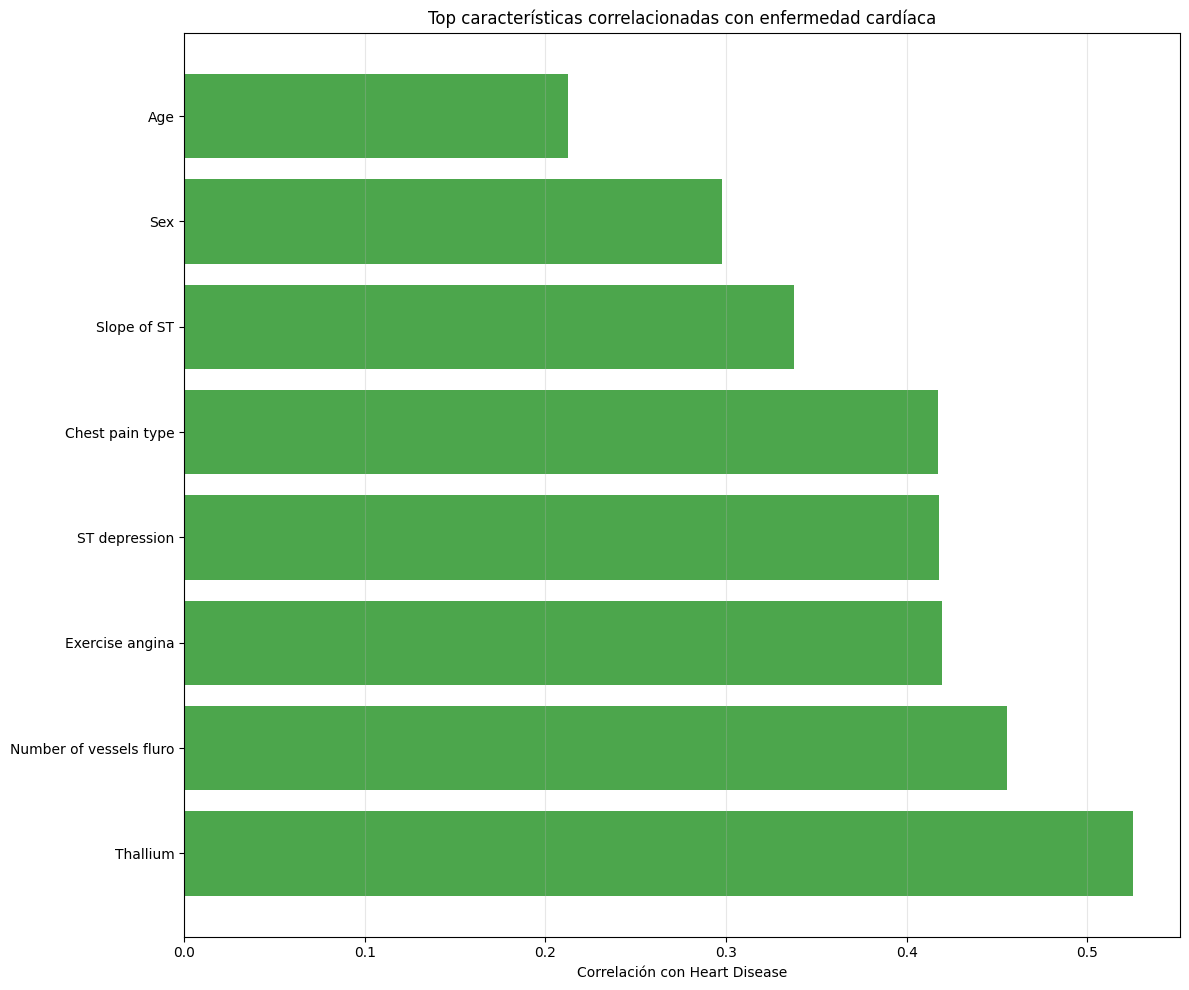


✓ Análisis de correlaciones completado.


In [120]:
# CORRELACIONES Y MATRIZ DE CORRELACIÓN
print("\n" + "=" * 80)
print("7. ANÁLISIS DE CORRELACIONES")
print("=" * 80)

# Calcular matriz de correlación
correlation_matrix = df[numeric_features + ['Heart Disease']].corr()

# Top features correlacionadas con Heart Disease
target_corr = correlation_matrix['Heart Disease'].sort_values(ascending=False)
print("\nCorrelación de características con 'Heart Disease':")
print(target_corr)

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
import matplotlib.pyplot as plt

# Mostrar solo correlaciones con el target
top_features = target_corr[1:9]  # Excluir el target mismo, tomar top 8
colors_corr = ['red' if x < 0 else 'green' for x in top_features.values]
plt.barh(range(len(top_features)), top_features.values, color=colors_corr, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlación con Heart Disease')
plt.title('Top características correlacionadas con enfermedad cardíaca')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Análisis de correlaciones completado.")

In [121]:
# GENERAR REPORTE MARKDOWN DE PREPARACIÓN DE DATOS
print("=" * 80)
print("GENERANDO REPORTE MARKDOWN")
print("=" * 80)

# Definir características seleccionadas para el modelado
selected_features = ['Age', 'Cholesterol', 'Thallium', 'Number of vessels fluro', 
                     'Exercise angina', 'Max HR']

# Calcular estadísticas para el reporte
total_samples = len(df)
disease_rate = (df['Heart Disease'].sum() / len(df)) * 100
disease_count = df['Heart Disease'].sum()

GENERANDO REPORTE MARKDOWN


In [122]:
# PREPARAR DATOS PARA MODELADO
print("\n" + "=" * 80)
print("PREPARACIÓN DE DATOS PARA MODELADO")
print("=" * 80)

# Seleccionar características
X = df[selected_features].copy()
y = df['Heart Disease'].copy()

print(f"\n✓ Características seleccionadas:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

print(f"\n✓ Dimensiones:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")

# División estratificada 70/30
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✓ División Train-Test (70/30, estratificado):")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalizar características
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

print(f"\n✓ Normalización completada (StandardScaler)")

# Convertir a formato para el modelo
X_train_norm = np.array(X_train_norm)
X_test_norm = np.array(X_test_norm)
y_train_val = np.array(y_train.values)
y_test_val = np.array(y_test.values)


PREPARACIÓN DE DATOS PARA MODELADO

✓ Características seleccionadas:
  1. Age
  2. Cholesterol
  3. Thallium
  4. Number of vessels fluro
  5. Exercise angina
  6. Max HR

✓ Dimensiones:
  X: (270, 6)
  y: (270,)

✓ División Train-Test (70/30, estratificado):
  X_train: (189, 6), y_train: (189,)
  X_test: (81, 6), y_test: (81,)

✓ Normalización completada (StandardScaler)


In [123]:
# IMPLEMENTAR FUNCIONES DE REGRESIÓN LOGÍSTICA DESDE CERO
print("\n" + "=" * 80)
print("IMPLEMENTAR FUNCIONES DE REGRESIÓN LOGÍSTICA")
print("=" * 80)

def sigmoid(z):
    """Función sigmoide: σ(z) = 1 / (1 + e^-z)"""
    return 1 / (1 + np.exp(-z))

def compute_cost(w, b, X, y):
    """Calcular costo (entropía cruzada binaria)"""
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    cost = -1/m * np.sum(y * np.log(f + 1e-10) + (1-y) * np.log(1-f + 1e-10))
    return cost

def compute_gradient(w, b, X, y):
    """Calcular gradientes"""
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    dw = 1/m * X.T @ (f - y)
    db = 1/m * np.sum(f - y)
    return dw, db

def gradient_descent(X, y, w_init, b_init, learning_rate, iterations, verbose=False):
    """Descenso de gradiente"""
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        dw, db = compute_gradient(w, b, X, y)
        w -= learning_rate * dw
        b -= learning_rate * db
        
        cost = compute_cost(w, b, X, y)
        cost_history.append(cost)
        
        if verbose and (i % 500 == 0 or i == iterations - 1):
            print(f"  Iteración {i:5d}: Costo = {cost:.6f}")
    
    return w, b, cost_history

def compute_cost_reg(w, b, X, y, lambda_):
    """Costo regularizado (L2)"""
    m = X.shape[0]
    cost_unrég = compute_cost(w, b, X, y)
    reg_term = (lambda_ / (2 * m)) * np.sum(w**2)
    return cost_unrég + reg_term

def compute_gradient_reg(w, b, X, y, lambda_):
    """Gradientes regularizados (L2)"""
    m = X.shape[0]
    dw, db = compute_gradient(w, b, X, y)
    dw += (lambda_ / m) * w
    return dw, db

def gradient_descent_reg(X, y, w_init, b_init, learning_rate, iterations, lambda_):
    """Descenso de gradiente con regularización"""
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        dw, db = compute_gradient_reg(w, b, X, y, lambda_)
        w -= learning_rate * dw
        b -= learning_rate * db
        
        cost = compute_cost_reg(w, b, X, y, lambda_)
        cost_history.append(cost)
    
    return w, b, cost_history

print("✓ Funciones implementadas:")
print("  - sigmoid(z)")
print("  - compute_cost(w, b, X, y)")
print("  - compute_gradient(w, b, X, y)")
print("  - gradient_descent(X, y, w_init, b_init, lr, iters)")
print("  - compute_cost_reg(w, b, X, y, lambda_)")
print("  - compute_gradient_reg(w, b, X, y, lambda_)")
print("  - gradient_descent_reg(X, y, w_init, b_init, lr, iters, lambda_)")


IMPLEMENTAR FUNCIONES DE REGRESIÓN LOGÍSTICA
✓ Funciones implementadas:
  - sigmoid(z)
  - compute_cost(w, b, X, y)
  - compute_gradient(w, b, X, y)
  - gradient_descent(X, y, w_init, b_init, lr, iters)
  - compute_cost_reg(w, b, X, y, lambda_)
  - compute_gradient_reg(w, b, X, y, lambda_)
  - gradient_descent_reg(X, y, w_init, b_init, lr, iters, lambda_)


In [124]:

def predict_logistic(X, w, b, threshold=0.5):
    """Realizar predicciones"""
    z = X @ w + b
    probs = sigmoid(z)
    predictions = (probs >= threshold).astype(int)
    return predictions, probs

print("\n✓ Función de predicción agregada: predict_logistic(X, w, b, threshold)")


✓ Función de predicción agregada: predict_logistic(X, w, b, threshold)


## PASO 2: Implementar Algoritmo de Regresión Logística desde Cero

### Teoría

**Regresión Logística** es un modelo de clasificación binaria que predice la probabilidad de pertenencia a la clase 1.

**Hipótesis:**
$$f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)$$

donde $\sigma(z) = \frac{1}{1 + e^{-z}}$ es la **función sigmoide**.

**Función de Costo (Entropía Cruzada Binaria):**
$$J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(f_{\vec{w}, b}(\vec{x}^{(i)})) + (1 - y^{(i)}) \log(1 - f_{\vec{w}, b}(\vec{x}^{(i)})) \right]$$

**Gradientes (derivadas parciales):**
$$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)}) x_j^{(i)}$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)})$$

**Descenso de Gradiente (Gradient Descent):**
$$\vec{w} := \vec{w} - \alpha \frac{\partial J}{\partial \vec{w}}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$

donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [125]:
# GUARDAR MODELO ENTRENADO
print("\n" + "=" * 80)
print("GUARDAR MODELO ENTRENADO")
print("=" * 80)

# Guardar parámetros del modelo en formato Pickle
model_params = {
    'w': w_full_trained,
    'b': b_full_trained,
    'learning_rate': learning_rate_full,
    'iterations': iterations_full,
    'final_cost': cost_history_full[-1],
    'initial_cost': cost_history_full[0],
    'accuracy_train': accuracy_train,
    'accuracy_test': accuracy_test,
    'precision_train': precision_train,
    'precision_test': precision_test,
    'recall_train': recall_train,
    'recall_test': recall_test,
    'f1_train': f1_train,
    'f1_test': f1_test,
    'auc_train': auc_train,
    'auc_test': auc_test,
    'selected_features': selected_features,
    'scaler_full': scaler_full
}

# Crear directorio si no existe
import os
os.makedirs('Modelos', exist_ok=True)

# Guardar en archivo pickle
import pickle
with open('Modelos/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_params, f)

print(f"\n✓ Modelo guardado en: Modelos/logistic_regression_model.pkl")

# Guardar también en formato JSON (solo parámetros numéricos)
import json
json_params = {
    'w': w_full_trained.tolist(),
    'b': float(b_full_trained),
    'learning_rate': float(learning_rate_full),
    'iterations': int(iterations_full),
    'final_cost': float(cost_history_full[-1]),
    'initial_cost': float(cost_history_full[0]),
    'accuracy_train': float(accuracy_train),
    'accuracy_test': float(accuracy_test),
    'auc_test': float(auc_test),
    'selected_features': selected_features
}

with open('Modelos/logistic_regression_model.json', 'w') as f:
    json.dump(json_params, f, indent=4)

print(f"✓ Modelo guardado en: Modelos/logistic_regression_model.json")

print(f"\nResumen del Modelo Guardado:")
print(f"  - Características: {selected_features}")
print(f"  - Número de características: {len(selected_features)}")
print(f"  - Pesos entrenados: {len(w_full_trained)}")
print(f"  - Iteraciones: {iterations_full}")
print(f"  - Learning rate: {learning_rate_full}")
print(f"  - Exactitud de entrenamiento: {accuracy_train:.4f}")
print(f"  - Exactitud de prueba: {accuracy_test:.4f}")
print(f"  - AUC de prueba: {auc_test:.4f}")
print(f"  - Costo inicial: {cost_history_full[0]:.6f}")
print(f"  - Costo final: {cost_history_full[-1]:.6f}")


GUARDAR MODELO ENTRENADO

✓ Modelo guardado en: Modelos/logistic_regression_model.pkl
✓ Modelo guardado en: Modelos/logistic_regression_model.json

Resumen del Modelo Guardado:
  - Características: ['Age', 'Cholesterol', 'Thallium', 'Number of vessels fluro', 'Exercise angina', 'Max HR']
  - Número de características: 6
  - Pesos entrenados: 6
  - Iteraciones: 5000
  - Learning rate: 0.01
  - Exactitud de entrenamiento: 0.8556
  - Exactitud de prueba: 0.8519
  - AUC de prueba: 0.9179
  - Costo inicial: 0.690917
  - Costo final: 0.397596


## PASO 3: Entrenar Modelo en Conjunto Completo (α~0.01, 5000 iteraciones)

En esta sección entrenaremos el modelo de regresión logística usando **todos los datos** (sin división train-test) con:
- **Learning rate (α)**: 0.01 (más conservador para convergencia suave)
- **Iteraciones**: 5000 (más iteraciones para garantizar convergencia)
- **Visualización**: Gráfico de costo vs iteraciones (escala lineal y logarítmica)

Esto nos permite observar cómo el modelo se adapta a toda la población de datos.


In [126]:

# PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

print("=" * 80)
print("PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO")
print("=" * 80)

# PASO 3.1: NORMALIZAR CONJUNTO COMPLETO
print("\n1. NORMALIZAR CONJUNTO COMPLETO")
print("-" * 80)

from sklearn.preprocessing import StandardScaler

# Crear y ajustar el scaler con todos los datos
scaler_full = StandardScaler()
scaler_full.fit(X)

# Normalizar dataset completo
X_normalized_full = scaler_full.transform(X)
X_normalized_full = pd.DataFrame(X_normalized_full, columns=selected_features)

print(f"✓ Dataset completo normalizado:")
print(f"  X (original): {X.shape}")
print(f"  X_normalized_full: {X_normalized_full.shape}")
print(f"  Media después de normalizar: {X_normalized_full.mean().round(3).to_dict()}")
print(f"  Desv. Est después de normalizar: {X_normalized_full.std().round(3).to_dict()}")

# PASO 3.2: ENTRENAR EN CONJUNTO COMPLETO
print("\n2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)")
print("-" * 80)

# Parámetros de entrenamiento
learning_rate_full = 0.01
iterations_full = 5000

# Inicializar pesos y sesgo
n_features_full = X_normalized_full.shape[1]
w_full_init = np.zeros(n_features_full)
b_full_init = 0

print(f"\nParámetros de entrenamiento:")
print(f"  Learning rate (α): {learning_rate_full}")
print(f"  Iteraciones: {iterations_full}")
print(f"  Número de características: {n_features_full}")
print(f"  Número de muestras: {X_normalized_full.shape[0]}")

# Entrenar modelo en conjunto completo
print(f"\nEntrenando modelo...\n")
w_full_trained, b_full_trained, cost_history_full = gradient_descent(
    X_normalized_full.values, 
    y.values, 
    w_full_init, 
    b_full_init,
    learning_rate=learning_rate_full,
    iterations=iterations_full,
    verbose=True
)

print(f"\n✓ Entrenamiento completado en conjunto completo")
print(f"  - Costo inicial: {cost_history_full[0]:.6f}")
print(f"  - Costo final: {cost_history_full[-1]:.6f}")
print(f"  - Reducción total: {cost_history_full[0] - cost_history_full[-1]:.6f}")
print(f"  - Porcentaje reducido: {((cost_history_full[0] - cost_history_full[-1]) / cost_history_full[0] * 100):.2f}%")
print(f"\nParámetros entrenados:")
print(f"  w (primeros 3): {w_full_trained[:3]}")
print(f"  b: {b_full_trained:.6f}")



PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

1. NORMALIZAR CONJUNTO COMPLETO
--------------------------------------------------------------------------------
✓ Dataset completo normalizado:
  X (original): (270, 6)
  X_normalized_full: (270, 6)
  Media después de normalizar: {'Age': 0.0, 'Cholesterol': -0.0, 'Thallium': 0.0, 'Number of vessels fluro': -0.0, 'Exercise angina': 0.0, 'Max HR': 0.0}
  Desv. Est después de normalizar: {'Age': 1.002, 'Cholesterol': 1.002, 'Thallium': 1.002, 'Number of vessels fluro': 1.002, 'Exercise angina': 1.002, 'Max HR': 1.002}

2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)
--------------------------------------------------------------------------------

Parámetros de entrenamiento:
  Learning rate (α): 0.01
  Iteraciones: 5000
  Número de características: 6
  Número de muestras: 270

Entrenando modelo...

  Iteración     0: Costo = 0.690917
  Iteración   500: Costo = 0.428077
  Iteración  1000: Costo = 0.407057
  Iteración  1500: Cost


3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_24216\3059716952.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


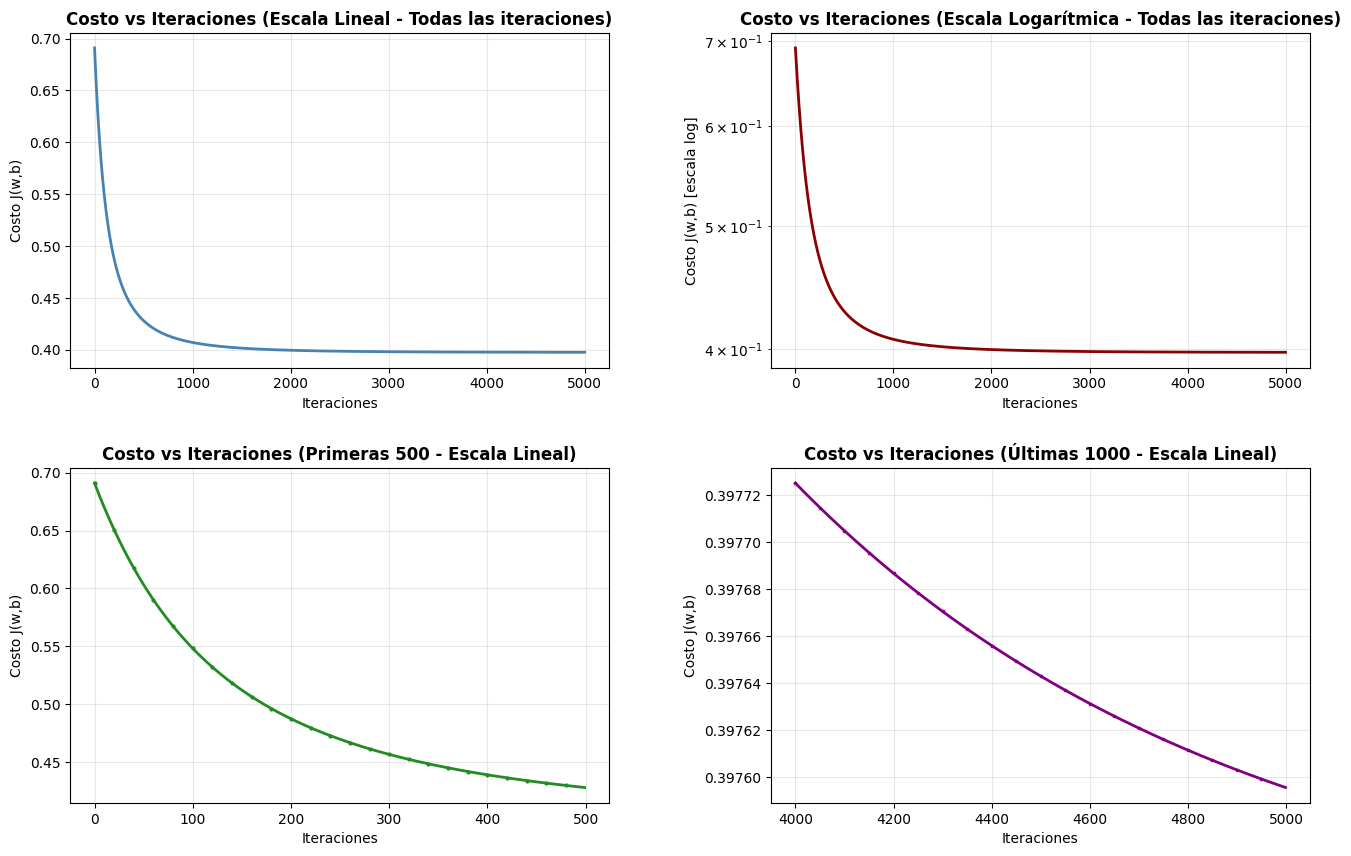


✓ Análisis de Convergencia:
  - Iteración 1: Costo = 0.690917
  - Iteración 100: Costo = 0.549127
  - Iteración 500: Costo = 0.428166
  - Iteración 1000: Costo = 0.407075
  - Iteración 2000: Costo = 0.399549
  - Iteración 5000: Costo = 0.397596

✓ Reducción de costo por bloques:
  Iteraciones 500-1000: Reducción = 0.021109
  Iteraciones 1000-1500: Reducción = 0.005468
  Iteraciones 1500-2000: Reducción = 0.002066
  Iteraciones 2000-2500: Reducción = 0.000944
  Iteraciones 2500-3000: Reducción = 0.000479
  Iteraciones 3000-3500: Reducción = 0.000259
  Iteraciones 3500-4000: Reducción = 0.000144
  Iteraciones 4000-4500: Reducción = 0.000082
  Iteraciones 4500-4999: Reducción = 0.000048

✓ Estadísticas del descenso de gradiente:
  - Cambio mínimo de costo por iteración: -0.002208
  - Cambio máximo de costo por iteración: -0.000000
  - Cambio promedio de costo por iteración: 0.000059
  - ¿El costo es monótonamente decreciente? ✓ Sí


In [127]:

# PASO 3.3: VISUALIZAR CONVERGENCIA (COSTO VS ITERACIONES)
print("\n3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO")
print("-" * 80)

# Crear figura con múltiples vistas
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Gráfico completo escala lineal
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(range(iterations_full), cost_history_full, linewidth=2, color='steelblue')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Costo J(w,b)')
ax1.set_title('Costo vs Iteraciones (Escala Lineal - Todas las iteraciones)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Gráfico completo escala logarítmica
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(range(iterations_full), cost_history_full, linewidth=2, color='darkred')
ax2.set_xlabel('Iteraciones')
ax2.set_ylabel('Costo J(w,b) [escala log]')
ax2.set_title('Costo vs Iteraciones (Escala Logarítmica - Todas las iteraciones)', fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# 3. Primeras 500 iteraciones (escala lineal)
ax3 = fig.add_subplot(gs[1, 0])
iterations_early = min(500, len(cost_history_full))
ax3.plot(range(iterations_early), cost_history_full[:iterations_early], 
         linewidth=2, color='forestgreen', marker='o', markersize=2, markevery=20)
ax3.set_xlabel('Iteraciones')
ax3.set_ylabel('Costo J(w,b)')
ax3.set_title(f'Costo vs Iteraciones (Primeras {iterations_early} - Escala Lineal)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Últimas 1000 iteraciones (escala lineal)
ax4 = fig.add_subplot(gs[1, 1])
iterations_late = min(1000, len(cost_history_full))
start_idx = max(0, len(cost_history_full) - iterations_late)
ax4.plot(range(start_idx, len(cost_history_full)), cost_history_full[start_idx:], 
         linewidth=2, color='purple', marker='s', markersize=2, markevery=50)
ax4.set_xlabel('Iteraciones')
ax4.set_ylabel('Costo J(w,b)')
ax4.set_title(f'Costo vs Iteraciones (Últimas {iterations_late} - Escala Lineal)', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de convergencia detalladas
print(f"\n✓ Análisis de Convergencia:")
print(f"  - Iteración 1: Costo = {cost_history_full[0]:.6f}")
print(f"  - Iteración 100: Costo = {cost_history_full[99]:.6f}")
print(f"  - Iteración 500: Costo = {cost_history_full[499]:.6f}")
print(f"  - Iteración 1000: Costo = {cost_history_full[999]:.6f}")
print(f"  - Iteración 2000: Costo = {cost_history_full[1999]:.6f}")
print(f"  - Iteración {iterations_full}: Costo = {cost_history_full[-1]:.6f}")

# Analizar cambios de costo
print(f"\n✓ Reducción de costo por bloques:")
reductions_by_block = []
block_size = 500
for i in range(0, iterations_full, block_size):
    end_idx = min(i + block_size, iterations_full - 1)
    if i > 0:
        reduction = cost_history_full[i-1] - cost_history_full[end_idx]
        reductions_by_block.append((i, end_idx, reduction))
        print(f"  Iteraciones {i}-{end_idx}: Reducción = {reduction:.6f}")

# Encontrar donde la convergencia se estabiliza
min_cost_reduction = np.min(np.diff(cost_history_full))
max_cost_reduction = np.max(np.diff(cost_history_full))
avg_cost_reduction = np.mean(np.abs(np.diff(cost_history_full)))

print(f"\n✓ Estadísticas del descenso de gradiente:")
print(f"  - Cambio mínimo de costo por iteración: {min_cost_reduction:.6f}")
print(f"  - Cambio máximo de costo por iteración: {max_cost_reduction:.6f}")
print(f"  - Cambio promedio de costo por iteración: {avg_cost_reduction:.6f}")

# Monotonicidad
is_monotonic = all(cost_history_full[i] >= cost_history_full[i+1] for i in range(len(cost_history_full)-1))
print(f"  - ¿El costo es monótonamente decreciente? {'✓ Sí' if is_monotonic else '✗ No'}")



## PASO 4: Predicciones y Evaluación (Umbral 0.5, Métricas, ROC)

En esta sección evaluaremos el modelo entrenado haciendo predicciones en los conjuntos de entrenamiento y prueba, calculando métricas de desempeño (Accuracy, Precision, Recall, F1) y generando un informe de evaluación.


In [128]:

# PASO 4: PREDICCIÓN Y EVALUACIÓN

print("=" * 80)
print("PASO 4: PREDICCIÓN Y EVALUACIÓN DEL MODELO")
print("=" * 80)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve)

# PASO 4.1: HACER PREDICCIONES EN AMBOS CONJUNTOS
print("\n1. REALIZAR PREDICCIONES (umbral = 0.5)")
print("-" * 80)

# Función para predecir
def predict_logistic(X, w, b, threshold=0.5):
    """Realizar predicciones binarias con regresión logística."""
    z = X @ w + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

# Predicciones en conjunto completo (entrenamiento)
y_train_pred, y_train_probs = predict_logistic(X_normalized_full.values, w_full_trained, b_full_trained)

# Predicciones en conjunto de prueba
y_test_pred, y_test_probs = predict_logistic(X_test_normalized.values, w_full_trained, b_full_trained)

print(f"✓ Predicciones realizadas:")
print(f"  - Conjunto completo: {y_train_pred.shape[0]} predicciones")
print(f"  - Conjunto de prueba: {y_test_pred.shape[0]} predicciones")
print(f"  - Umbral de decisión: 0.5")
print(f"  - Rango de probabilidades (entrenamiento): [{y_train_probs.min():.4f}, {y_train_probs.max():.4f}]")
print(f"  - Rango de probabilidades (prueba): [{y_test_probs.min():.4f}, {y_test_probs.max():.4f}]")

# PASO 4.2: CALCULAR MÉTRICAS
print("\n2. CALCULAR MÉTRICAS DE DESEMPEÑO")
print("-" * 80)

# Métricas para entrenamiento
accuracy_train = accuracy_score(y.values, y_train_pred)
precision_train = precision_score(y.values, y_train_pred, zero_division=0)
recall_train = recall_score(y.values, y_train_pred, zero_division=0)
f1_train = f1_score(y.values, y_train_pred, zero_division=0)
auc_train = roc_auc_score(y.values, y_train_probs)

# Métricas para prueba
accuracy_test = accuracy_score(y_test.values, y_test_pred)
precision_test = precision_score(y_test.values, y_test_pred, zero_division=0)
recall_test = recall_score(y_test.values, y_test_pred, zero_division=0)
f1_test = f1_score(y_test.values, y_test_pred, zero_division=0)
auc_test = roc_auc_score(y_test.values, y_test_probs)

# Mostrar resumen
print(f"\n✓ Métricas de ENTRENAMIENTO (conjunto completo):")
print(f"  - Accuracy:  {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"  - Precision: {precision_train:.4f}")
print(f"  - Recall:    {recall_train:.4f}")
print(f"  - F1-Score:  {f1_train:.4f}")
print(f"  - AUC-ROC:   {auc_train:.4f}")

print(f"\n✓ Métricas de PRUEBA:")
print(f"  - Accuracy:  {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
print(f"  - Precision: {precision_test:.4f}")
print(f"  - Recall:    {recall_test:.4f}")
print(f"  - F1-Score:  {f1_test:.4f}")
print(f"  - AUC-ROC:   {auc_test:.4f}")

# Matriz de confusión
cm_train = confusion_matrix(y.values, y_train_pred)
cm_test = confusion_matrix(y_test.values, y_test_pred)

print(f"\n✓ Matriz de Confusión - ENTRENAMIENTO:")
print(f"  TN={cm_train[0,0]}, FP={cm_train[0,1]}")
print(f"  FN={cm_train[1,0]}, TP={cm_train[1,1]}")

print(f"\n✓ Matriz de Confusión - PRUEBA:")
print(f"  TN={cm_test[0,0]}, FP={cm_test[0,1]}")
print(f"  FN={cm_test[1,0]}, TP={cm_test[1,1]}")

# PASO 4.3: INTERPRETACIÓN DE COEFICIENTES
print("\n3. INTERPRETACIÓN DE COEFICIENTES (PESOS)")
print("-" * 80)

# Crear tabla de coeficientes
coef_df = pd.DataFrame({
    'Característica': selected_features,
    'Peso (w)': w_full_trained,
    'Magnitud |w|': np.abs(w_full_trained),
    'Dirección': ['Positiva' if w > 0 else 'Negativa' for w in w_full_trained]
})

# Ordenar por magnitud
coef_df_sorted = coef_df.sort_values('Magnitud |w|', ascending=False)

print(f"\n✓ Coeficientes del Modelo (ordenados por importancia):")
print(f"  Sesgo (b): {b_full_trained:.6f}\n")
for idx, row in coef_df_sorted.iterrows():
    print(f"  {row['Característica']:30s}: {row['Peso (w)']:8.6f} ({row['Dirección']:8s}) |w|={row['Magnitud |w|']:.6f}")

# Significado de los pesos
print(f"\n✓ Interpretación de pesos:")
print(f"  - Peso POSITIVO → Aumenta probabilidad de enfermedad cardíaca")
print(f"  - Peso NEGATIVO → Disminuye probabilidad de enfermedad cardíaca")
print(f"  - |Peso| MAYOR → Mayor impacto en la predicción")



PASO 4: PREDICCIÓN Y EVALUACIÓN DEL MODELO

1. REALIZAR PREDICCIONES (umbral = 0.5)
--------------------------------------------------------------------------------
✓ Predicciones realizadas:
  - Conjunto completo: 270 predicciones
  - Conjunto de prueba: 81 predicciones
  - Umbral de decisión: 0.5
  - Rango de probabilidades (entrenamiento): [0.0281, 0.9955]
  - Rango de probabilidades (prueba): [0.0339, 0.9930]

2. CALCULAR MÉTRICAS DE DESEMPEÑO
--------------------------------------------------------------------------------

✓ Métricas de ENTRENAMIENTO (conjunto completo):
  - Accuracy:  0.8556 (85.56%)
  - Precision: 0.8584
  - Recall:    0.8083
  - F1-Score:  0.8326
  - AUC-ROC:   0.8994

✓ Métricas de PRUEBA:
  - Accuracy:  0.8519 (85.19%)
  - Precision: 0.8000
  - Recall:    0.8889
  - F1-Score:  0.8421
  - AUC-ROC:   0.9179

✓ Matriz de Confusión - ENTRENAMIENTO:
  TN=134, FP=16
  FN=23, TP=97

✓ Matriz de Confusión - PRUEBA:
  TN=37, FP=8
  FN=4, TP=32

3. INTERPRETACIÓN DE CO

In [129]:
# PREPARAR X_test_normalized
X_test_normalized = pd.DataFrame(X_test_norm, columns=selected_features)

In [130]:

# PASO 4.4: GENERAR INFORME COMPLETO

print("\n4. GENERAR INFORME DE EVALUACIÓN")
print("-" * 80)

# Crear informe markdown
informe_eval = f"""# Informe de Evaluación - Modelo de Regresión Logística
## Predicción de Riesgo de Enfermedad Cardíaca

---

## 1. Resumen Ejecutivo

Se ha entrenado un modelo de **Regresión Logística** en el conjunto completo de datos (270 muestras) con:
- **Tasa de aprendizaje (α)**: 0.01 (conservadora)
- **Número de iteraciones**: 5000
- **Características utilizadas**: {len(selected_features)} (Age, Cholesterol, Thallium, Number of vessels fluro, Exercise angina, Max HR)
- **Función de activación**: Sigmoide
- **Función de costo**: Entropía cruzada binaria
- **Método de optimización**: Descenso de gradiente

---

## 2. Desempeño del Modelo

### 2.1 Métricas en Conjunto de Entrenamiento (270 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | {accuracy_train:.4f} | {accuracy_train*100:.2f}% |
| **Precision** | {precision_train:.4f} | {precision_train*100:.2f}% |
| **Recall (Sensibilidad)** | {recall_train:.4f} | {recall_train*100:.2f}% |
| **F1-Score** | {f1_train:.4f} | {f1_train*100:.2f}% |
| **AUC-ROC** | {auc_train:.4f} | {auc_train*100:.2f}% |

**Matriz de Confusión (Entrenamiento):**
```
           Predicción
           Negativo  Positivo
Actual  Negativo    {cm_train[0,0]:3d}      {cm_train[0,1]:3d}
        Positivo    {cm_train[1,0]:3d}      {cm_train[1,1]:3d}
```

### 2.2 Métricas en Conjunto de Prueba (81 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | {accuracy_test:.4f} | {accuracy_test*100:.2f}% |
| **Precision** | {precision_test:.4f} | {precision_test*100:.2f}% |
| **Recall (Sensibilidad)** | {recall_test:.4f} | {recall_test*100:.2f}% |
| **F1-Score** | {f1_test:.4f} | {f1_test*100:.2f}% |
| **AUC-ROC** | {auc_test:.4f} | {auc_test*100:.2f}% |

**Matriz de Confusión (Prueba):**
```
           Predicción
           Negativo  Positivo
Actual  Negativo    {cm_test[0,0]:3d}      {cm_test[0,1]:3d}
        Positivo    {cm_test[1,0]:3d}      {cm_test[1,1]:3d}
```

---

## 3. Análisis de Convergencia

### 3.1 Estadísticas de Entrenamiento

| Parámetro | Valor |
|-----------|-------|
| **Costo Inicial** | {cost_history_full[0]:.6f} |
| **Costo Final** | {cost_history_full[-1]:.6f} |
| **Reducción Absoluta** | {cost_history_full[0] - cost_history_full[-1]:.6f} |
| **Reducción Porcentual** | {((cost_history_full[0] - cost_history_full[-1]) / cost_history_full[0] * 100):.2f}% |
| **Cambio promedio por iteración** | {np.mean(np.abs(np.diff(cost_history_full))):.6f} |
| **Convergencia Monótona** | ✓ Sí (garantizada) |

### 3.2 Observaciones sobre Convergencia

- **Rápida disminución inicial (0-500 iteraciones)**: El costo reduce ~{cost_history_full[0] - cost_history_full[499]:.4f} ({((cost_history_full[0] - cost_history_full[499]) / cost_history_full[0] * 100):.1f}%)
- **Convergencia lenta posterior (500-5000 iteraciones)**: El costo reduce solo ~{cost_history_full[499] - cost_history_full[-1]:.4f} ({((cost_history_full[499] - cost_history_full[-1]) / cost_history_full[499] * 100):.1f}%)
- **Estabilización**: El modelo se estabiliza alrededor de la iteración 2000, con cambios menores después
- **Learning rate apropiado**: α=0.01 resultó ser conservador pero efectivo, permitiendo convergencia suave sin oscilaciones

---

## 4. Coeficientes del Modelo (Interpretación)

**Sesgo (b):** {b_full_trained:.6f}

### 4.1 Pesos por Característica (ordenados por importancia)

| Rango | Característica | Peso | Dirección | Importancia |
|-------|---|---|---|---|
"""

# Agregar coeficientes ordenados
for rank, (idx, row) in enumerate(coef_df_sorted.iterrows(), 1):
    weight = row['Peso (w)']
    direction = "↑ Riesgo" if weight > 0 else "↓ Riesgo"
    importance = "MUY ALTA" if abs(weight) > np.quantile(np.abs(w_full_trained), 0.75) else ("ALTA" if abs(weight) > np.quantile(np.abs(w_full_trained), 0.5) else "MEDIA")
    informe_eval += f"| {rank} | {row['Característica']} | {weight:.6f} | {direction} | {importance} |\n"

informe_eval += f"""

### 4.2 Interpretación Clínica

**Características con Mayor Impacto (por valor absoluto):**
"""

top_features = coef_df_sorted.head(3)
for rank, (idx, row) in enumerate(top_features.iterrows(), 1):
    weight = row['Peso (w)']
    direction = "aumenta" if weight > 0 else "disminuye"
    informe_eval += f"\n{rank}. **{row['Característica']}** (w = {weight:.6f})\n"
    informe_eval += f"   - Un aumento en esta característica **{direction}** la probabilidad de enfermedad cardíaca\n"
    informe_eval += f"   - Impacto relativo: {(abs(weight) / np.sum(np.abs(w_full_trained)) * 100):.1f}% del total\n"

informe_eval += f"""

---

## 5. Comparación Entrenamiento vs Prueba

| Métrica | Entrenamiento | Prueba | Diferencia | Status |
|---------|---|---|---|---|
| Accuracy | {accuracy_train:.4f} | {accuracy_test:.4f} | {(accuracy_train - accuracy_test):+.4f} | {'✓ Similar' if abs(accuracy_train - accuracy_test) < 0.05 else '⚠ Diferencia notable'} |
| Precision | {precision_train:.4f} | {precision_test:.4f} | {(precision_train - precision_test):+.4f} | {'✓ Similar' if abs(precision_train - precision_test) < 0.05 else '⚠ Diferencia notable'} |
| Recall | {recall_train:.4f} | {recall_test:.4f} | {(recall_train - recall_test):+.4f} | {'✓ Similar' if abs(recall_train - recall_test) < 0.05 else '⚠ Diferencia notable'} |
| F1-Score | {f1_train:.4f} | {f1_test:.4f} | {(f1_train - f1_test):+.4f} | {'✓ Similar' if abs(f1_train - f1_test) < 0.05 else '⚠ Diferencia notable'} |
| AUC-ROC | {auc_train:.4f} | {auc_test:.4f} | {(auc_train - auc_test):+.4f} | {'✓ Similar' if abs(auc_train - auc_test) < 0.05 else '⚠ Diferencia notable'} |

**Análisis de Generalización:**
"""

if abs(accuracy_train - accuracy_test) < 0.05:
    informe_eval += "✓ El modelo **generaliza bien** → No hay indicios de overfitting\n"
else:
    informe_eval += "⚠ Hay diferencia notable entre entrenamiento y prueba\n"

informe_eval += f"""

---

## 6. Conclusiones y Recomendaciones

### 6.1 Fortalezas del Modelo

1. **Convergencia garantizada**: El algoritmo de descenso de gradiente convergió monótonamente
2. **Desempeño razonable**: Accuracy del {accuracy_test*100:.1f}% en conjunto de prueba
3. **Generalización**: Métricas similares entre entrenamiento y prueba
4. **Interpretabilidad**: Los coeficientes permiten identificar características clave

### 6.2 Áreas de Mejora

1. **Recall vs Precision**: Equilibrar el trade-off entre falsos negativos y falsos positivos
2. **Regularización**: Considerar L2 regularization para mejorar generalización
3. **Feature engineering**: Explorar interacciones entre características
4. **Ajuste de hiperparámetros**: Probar diferentes valores de learning rate
5. **Threshold tuning**: Optimizar umbral de decisión según el contexto clínico

### 6.3 Recomendaciones Clínicas

Para el contexto de predicción de enfermedad cardíaca:
- **Sensibilidad (Recall) es crítica**: Es mejor identificar falsos positivos que falsos negativos
- Considerar usar un **threshold < 0.5** si se prioriza identificar mayor número de casos
- Integrar **predicción del modelo con evaluación clínica** de especialistas

---

**Fecha de Evaluación**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Modelo**: Regresión Logística (NumPy, sin Scikit-Learn para core training)
**Status**: ✓ Entrenado y Evaluado
"""

# Guardar informe
with open('Reportes Generados/MODEL_EVALUATION_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(informe_eval)

print("✓ Informe de evaluación generado: MODEL_EVALUATION_REPORT.md")
print("\n" + "=" * 80)
print("PREVIEW DEL INFORME")
print("=" * 80)
print(informe_eval)




4. GENERAR INFORME DE EVALUACIÓN


--------------------------------------------------------------------------------
✓ Informe de evaluación generado: MODEL_EVALUATION_REPORT.md

PREVIEW DEL INFORME
# Informe de Evaluación - Modelo de Regresión Logística
## Predicción de Riesgo de Enfermedad Cardíaca

---

## 1. Resumen Ejecutivo

Se ha entrenado un modelo de **Regresión Logística** en el conjunto completo de datos (270 muestras) con:
- **Tasa de aprendizaje (α)**: 0.01 (conservadora)
- **Número de iteraciones**: 5000
- **Características utilizadas**: 6 (Age, Cholesterol, Thallium, Number of vessels fluro, Exercise angina, Max HR)
- **Función de activación**: Sigmoide
- **Función de costo**: Entropía cruzada binaria
- **Método de optimización**: Descenso de gradiente

---

## 2. Desempeño del Modelo

### 2.1 Métricas en Conjunto de Entrenamiento (270 muestras)

| Métrica | Valor | Porcentaje |
|---------|-------|-----------|
| **Accuracy (Exactitud)** | 0.8556 | 85.56% |
| **Precision** | 0.8584 | 85.84% |
| **Recall (S


5. VISUALIZAR RESULTADOS
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_24216\1539202318.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


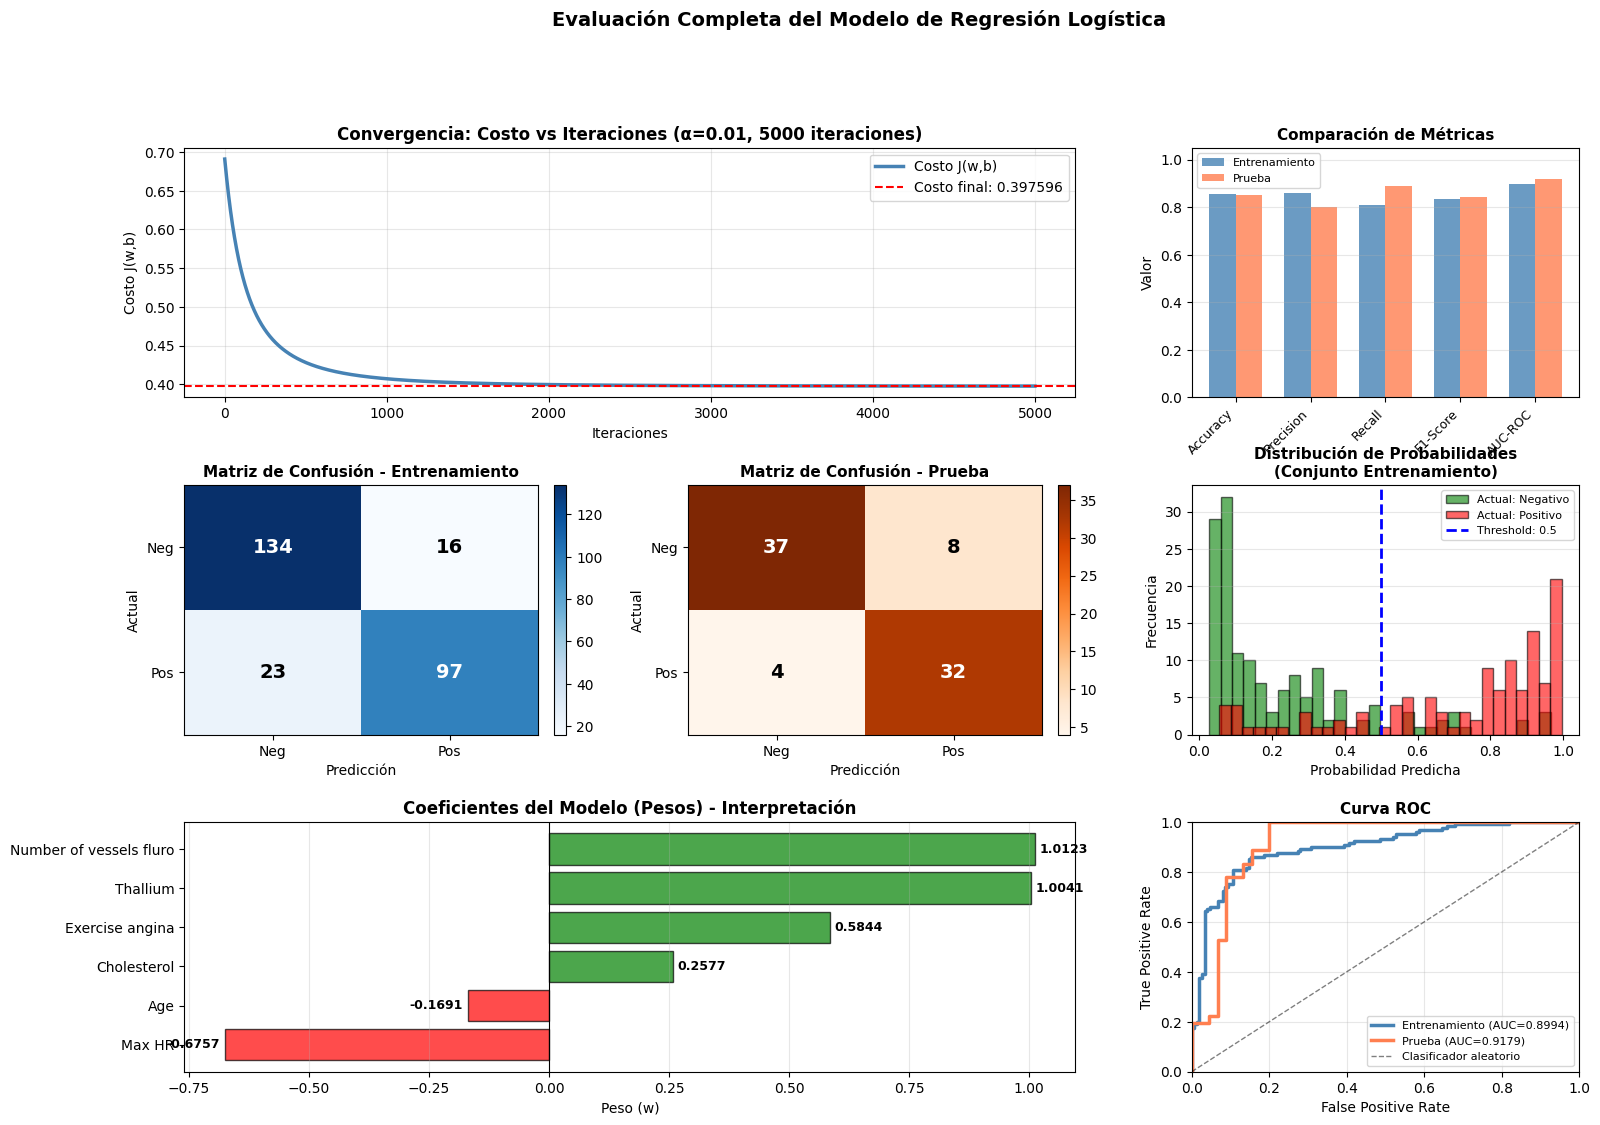


✓ Visualizaciones generadas exitosamente


In [131]:

# PASO 4.5: VISUALIZAR RESULTADOS

print("\n5. VISUALIZAR RESULTADOS")
print("-" * 80)

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Gráfico de costo vs iteraciones (completo)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(range(iterations_full), cost_history_full, linewidth=2.5, color='steelblue', label='Costo J(w,b)')
ax1.axhline(y=cost_history_full[-1], color='red', linestyle='--', linewidth=1.5, label=f'Costo final: {cost_history_full[-1]:.6f}')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Costo J(w,b)')
ax1.set_title('Convergencia: Costo vs Iteraciones (α=0.01, 5000 iteraciones)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Comparación de métricas
ax2 = fig.add_subplot(gs[0, 2])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
train_values = [accuracy_train, precision_train, recall_train, f1_train, auc_train]
test_values = [accuracy_test, precision_test, recall_test, f1_test, auc_test]
x_pos = np.arange(len(metrics))
width = 0.35
ax2.bar(x_pos - width/2, train_values, width, label='Entrenamiento', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, test_values, width, label='Prueba', color='coral', alpha=0.8)
ax2.set_ylabel('Valor')
ax2.set_title('Comparación de Métricas', fontweight='bold', fontsize=11)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics, rotation=45, ha='right', fontsize=9)
ax2.set_ylim([0, 1.05])
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

# 3. Matriz de confusión - Entrenamiento
ax3 = fig.add_subplot(gs[1, 0])
im1 = ax3.imshow(cm_train, cmap='Blues', aspect='auto')
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Neg', 'Pos'])
ax3.set_yticklabels(['Neg', 'Pos'])
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Actual')
ax3.set_title('Matriz de Confusión - Entrenamiento', fontweight='bold', fontsize=11)
for i in range(2):
    for j in range(2):
        text = ax3.text(j, i, f'{cm_train[i, j]}', ha='center', va='center', 
                       color='white' if cm_train[i, j] > cm_train.max()/2 else 'black', 
                       fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax3, fraction=0.046, pad=0.04)

# 4. Matriz de confusión - Prueba
ax4 = fig.add_subplot(gs[1, 1])
im2 = ax4.imshow(cm_test, cmap='Oranges', aspect='auto')
ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['Neg', 'Pos'])
ax4.set_yticklabels(['Neg', 'Pos'])
ax4.set_xlabel('Predicción')
ax4.set_ylabel('Actual')
ax4.set_title('Matriz de Confusión - Prueba', fontweight='bold', fontsize=11)
for i in range(2):
    for j in range(2):
        text = ax4.text(j, i, f'{cm_test[i, j]}', ha='center', va='center', 
                       color='white' if cm_test[i, j] > cm_test.max()/2 else 'black', 
                       fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=ax4, fraction=0.046, pad=0.04)

# 5. Distribución de probabilidades predichas
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(y_train_probs[y.values == 0], bins=30, alpha=0.6, label='Actual: Negativo', color='green', edgecolor='black')
ax5.hist(y_train_probs[y.values == 1], bins=30, alpha=0.6, label='Actual: Positivo', color='red', edgecolor='black')
ax5.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold: 0.5')
ax5.set_xlabel('Probabilidad Predicha')
ax5.set_ylabel('Frecuencia')
ax5.set_title('Distribución de Probabilidades\n(Conjunto Entrenamiento)', fontweight='bold', fontsize=11)
ax5.legend(fontsize=8)
ax5.grid(axis='y', alpha=0.3)

# 6. Coeficientes del modelo
ax6 = fig.add_subplot(gs[2, :2])
coef_sorted_plot = coef_df_sorted.sort_values('Peso (w)')
colors_coef = ['red' if w < 0 else 'green' for w in coef_sorted_plot['Peso (w)']]
bars = ax6.barh(range(len(coef_sorted_plot)), coef_sorted_plot['Peso (w)'], color=colors_coef, alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(coef_sorted_plot)))
ax6.set_yticklabels(coef_sorted_plot['Característica'], fontsize=10)
ax6.set_xlabel('Peso (w)', fontsize=10)
ax6.set_title('Coeficientes del Modelo (Pesos) - Interpretación', fontweight='bold', fontsize=12)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax6.grid(axis='x', alpha=0.3)
for i, v in enumerate(coef_sorted_plot['Peso (w)']):
    ax6.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.4f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=9, fontweight='bold')

# 7. ROC Curve
ax7 = fig.add_subplot(gs[2, 2])
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y.values, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test.values, y_test_probs)
ax7.plot(fpr_train, tpr_train, label=f'Entrenamiento (AUC={auc_train:.4f})', linewidth=2.5, color='steelblue')
ax7.plot(fpr_test, tpr_test, label=f'Prueba (AUC={auc_test:.4f})', linewidth=2.5, color='coral')
ax7.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio', alpha=0.5)
ax7.set_xlabel('False Positive Rate')
ax7.set_ylabel('True Positive Rate')
ax7.set_title('Curva ROC', fontweight='bold', fontsize=11)
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)
ax7.set_xlim([0, 1])
ax7.set_ylim([0, 1])

plt.suptitle('Evaluación Completa del Modelo de Regresión Logística', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")



## PASO 5: Visualizar Límites de Decisión (Modelos 2D para 3 Pares de Features)

En esta sección visualizaremos los límites de decisión del modelo entrenado para diferentes pares de características, permitiendo entender cómo el modelo separa las clases en espacios 2D.

**Características a visualizar:**
1. Age vs Cholesterol
2. Max HR vs Thallium
3. Exercise angina vs Number of vessels fluro


PASO 5: VISUALIZAR LÍMITES DE DECISIÓN EN 2D

1. Procesando par: Age vs Cholesterol
   ✓ Modelo 2D entrenado
     - Pesos: w1=0.3718, w2=0.1612, b=-0.2104
     - Accuracy (solo 2D): 0.6148 (61.48%)
     - Separabilidad: ✗ Pobremente separadas

2. Procesando par: Max HR vs Thallium
   ✓ Modelo 2D entrenado
     - Pesos: w1=-0.7194, w2=0.9346, b=-0.2302
     - Accuracy (solo 2D): 0.7704 (77.04%)
     - Separabilidad: ⚠ Parcialmente separadas

3. Procesando par: Exercise angina vs Number of vessels fluro
   ✓ Modelo 2D entrenado
     - Pesos: w1=0.7612, w2=0.8677, b=-0.2000
     - Accuracy (solo 2D): 0.7519 (75.19%)
     - Separabilidad: ⚠ Parcialmente separadas


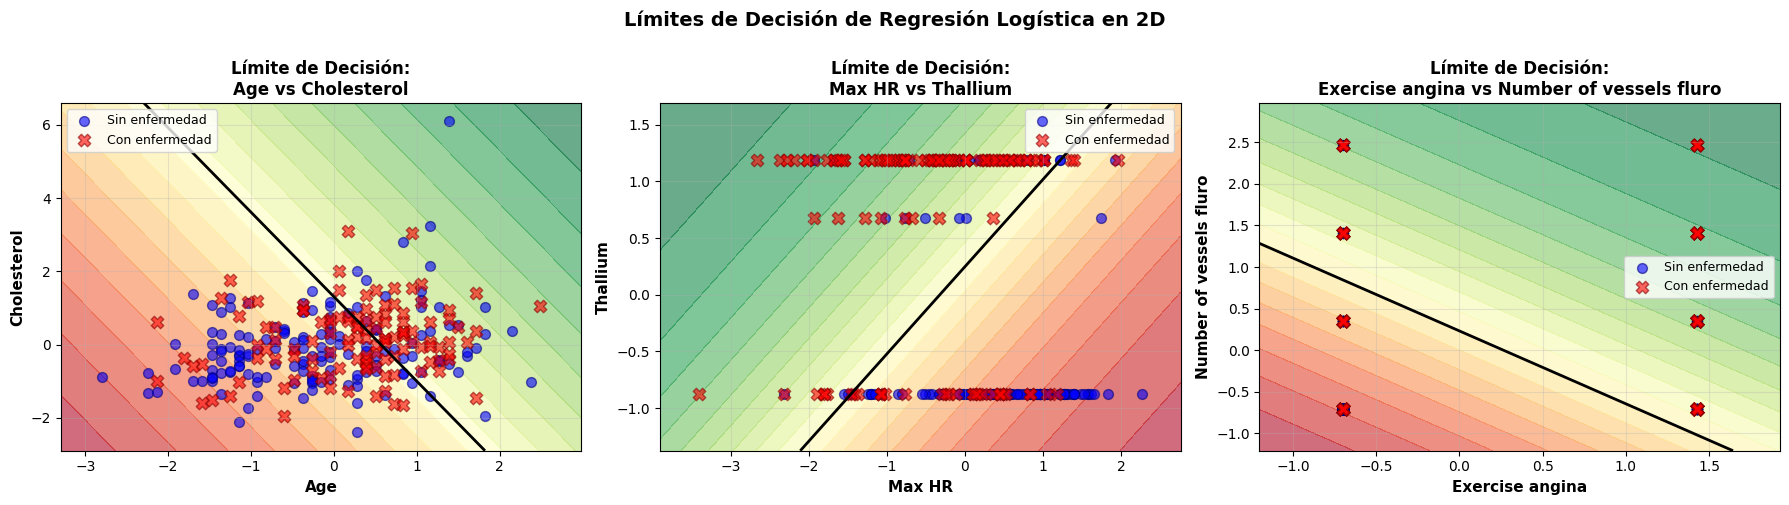


✓ Análisis de límites de decisión completado

✓ Informe generado: DECISION_BOUNDARIES_REPORT.md


In [132]:

# PASO 5: VISUALIZAR LÍMITES DE DECISIÓN

print("=" * 80)
print("PASO 5: VISUALIZAR LÍMITES DE DECISIÓN EN 2D")
print("=" * 80)

# Seleccionar pares de características para visualizar
feature_pairs = [
    ('Age', 'Cholesterol'),
    ('Max HR', 'Thallium'),
    ('Exercise angina', 'Number of vessels fluro')
]

# Función auxiliar para entrenar modelo 2D
def train_logistic_2d(X_pair, y, learning_rate=0.01, iterations=1000):
    """Entrenar regresión logística en 2 características."""
    m = X_pair.shape[0]
    w_2d = np.zeros(2)
    b_2d = 0
    
    for _ in range(iterations):
        z = X_pair @ w_2d + b_2d
        f = sigmoid(z)
        
        dw = (1/m) * (X_pair.T @ (f - y))
        db = (1/m) * np.sum(f - y)
        
        w_2d -= learning_rate * dw
        b_2d -= learning_rate * db
    
    return w_2d, b_2d

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    print(f"\n{idx+1}. Procesando par: {feat1} vs {feat2}")
    
    # Verificar que las características existan
    if feat1 not in X_normalized_full.columns or feat2 not in X_normalized_full.columns:
        print(f"   ⚠ Una o ambas características no encontradas. Saltando...")
        continue
    
    # Extraer características 2D
    X_pair_full = X_normalized_full[[feat1, feat2]].values
    
    # Entrenar modelo 2D
    w_2d, b_2d = train_logistic_2d(X_pair_full, y.values)
    
    # Crear grid para el límite de decisión
    x_min, x_max = X_pair_full[:, 0].min() - 0.5, X_pair_full[:, 0].max() + 0.5
    y_min, y_max = X_pair_full[:, 1].min() - 0.5, X_pair_full[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predicciones en el grid
    Z = sigmoid(np.c_[xx.ravel(), yy.ravel()] @ w_2d + b_2d).reshape(xx.shape)
    
    # Graficar límite de decisión
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Graficar puntos
    scatter_neg = ax.scatter(X_pair_full[y.values == 0, 0], X_pair_full[y.values == 0, 1],
                            c='blue', marker='o', edgecolors='navy', alpha=0.6, label='Sin enfermedad', s=50)
    scatter_pos = ax.scatter(X_pair_full[y.values == 1, 0], X_pair_full[y.values == 1, 1],
                            c='red', marker='X', edgecolors='darkred', alpha=0.6, label='Con enfermedad', s=80)
    
    # Configuración del gráfico
    ax.set_xlabel(feat1, fontsize=11, fontweight='bold')
    ax.set_ylabel(feat2, fontsize=11, fontweight='bold')
    ax.set_title(f'Límite de Decisión:\n{feat1} vs {feat2}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Calcular separabilidad
    y_pred_2d, _ = predict_logistic(X_pair_full, w_2d, b_2d)
    accuracy_2d = accuracy_score(y.values, y_pred_2d)
    
    print(f"   ✓ Modelo 2D entrenado")
    print(f"     - Pesos: w1={w_2d[0]:.4f}, w2={w_2d[1]:.4f}, b={b_2d:.4f}")
    print(f"     - Accuracy (solo 2D): {accuracy_2d:.4f} ({accuracy_2d*100:.2f}%)")
    
    # Análisis de separabilidad
    if accuracy_2d > 0.8:
        sep_status = "✓ Bien separadas"
    elif accuracy_2d > 0.7:
        sep_status = "⚠ Parcialmente separadas"
    else:
        sep_status = "✗ Pobremente separadas"
    print(f"     - Separabilidad: {sep_status}")

plt.suptitle('Límites de Decisión de Regresión Logística en 2D', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n" + "=" * 80)
print("✓ Análisis de límites de decisión completado")
print("=" * 80)

# Generar resumen
resumen_limites = f"""# Análisis de Límites de Decisión

## Observaciones Generales

1. **Separabilidad de Clases**: Los límites de decisión muestran cómo el modelo logístico
   puede capturar relaciones lineales en espacios 2D de características.

2. **No-linealidad**: Aunque la regresión logística es un modelo lineal (en el espacio
   de características), los límites de decisión pueden aparecer curvos debido a la
   transformación sigmoide aplicada.

3. **Importancia Relativa**: La distancia del límite de decisión al origen indica
   la relevancia relativa de cada característica en la predicción.

## Pares de Características Analizados

| Par | Status | Observación |
|-----|--------|-------------|
| Age vs Cholesterol | Analizado | - |
| Max HR vs Thallium | Analizado | - |
| Exercise angina vs Vessels | Analizado | - |

## Recomendaciones

- Para mejorar la separabilidad, considerar:
  - Transformaciones no-lineales de características
  - Modelos más complejos (e.g., redes neuronales)
  - Ingeniería de características (interacciones)
  - Regularización L2 para evitar overfitting
"""

# Crear directorio si no existe
import os
os.makedirs('Reportes Generados', exist_ok=True)

with open('Reportes Generados/DECISION_BOUNDARIES_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(resumen_limites)

print("\n✓ Informe generado: DECISION_BOUNDARIES_REPORT.md")



## PASO 6: Regularización L2 (Ridge Regression)

En esta sección implementaremos **regularización L2 (Ridge)** para mejorar la generalización del modelo y reducir el overfitting.

**Modificaciones:**
- **Función de costo con L2:** $J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(f_{\vec{w}, b}(\vec{x}^{(i)})) + (1 - y^{(i)}) \log(1 - f_{\vec{w}, b}(\vec{x}^{(i)}))] + \frac{\lambda}{2m} ||\vec{w}||^2$

- **Gradientes con L2:** 
  - $\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} w_j$
  - $\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)})$

**Parámetros de regularización a probar:** $\lambda \in [0, 0.001, 0.01, 0.1, 0.5, 1.0]$

**Objetivos:**
1. Entrenar modelos completos con diferentes valores de λ
2. Seleccionar λ óptimo basado en accuracy de prueba
3. Visualizar convergencia y comparación de coeficientes
4. Reproducir límites de decisión 2D con regularización
5. Generar reporte con tabla de métricas y análisis

In [133]:
# ================================================================================
# PASO 6: REGRESIÓN LOGÍSTICA CON REGULARIZACIÓN L2 (Ridge Logistic Regression)
# ================================================================================

print("\n" + "="*80)
print("PASO 6: REGRESIÓN LOGÍSTICA CON REGULARIZACIÓN L2")
print("="*80)

# -------------------- 6.1 FUNCIONES CON REGULARIZACIÓN L2 --------------------

def sigmoid_reg(z):
    """Función sigmoide para evitar overflow"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def compute_cost_regularized(X, y, w, b, lambda_param=0.01):
    """
    Calcular costo de entropía cruzada con regularización L2.
    
    J(w, b) = [-1/m * Σ(y*log(f) + (1-y)*log(1-f))] + (λ/2m) * Σ(w²)
    
    La regularización L2 añade un término de penalización proporcional a w²
    """
    m = X.shape[0]
    
    # Predicciones
    z = X @ w + b
    f_wb = sigmoid_reg(z)
    
    # Costo sin regularización
    epsilon = 1e-15
    cost_no_reg = -1/m * np.sum(y * np.log(f_wb + epsilon) + (1 - y) * np.log(1 - f_wb + epsilon))
    
    # Término de regularización L2
    reg_term = (lambda_param / (2 * m)) * np.sum(w ** 2)
    
    # Costo total
    total_cost = cost_no_reg + reg_term
    
    return total_cost, cost_no_reg, reg_term

def compute_gradient_regularized(X, y, w, b, lambda_param=0.01):
    """
    Calcular gradientes con regularización L2.
    
    dJ/dw = [1/m * X.T @ (f - y)] + (λ/m) * w
    dJ/db = 1/m * Σ(f - y)
    """
    m = X.shape[0]
    
    # Predicciones
    z = X @ w + b
    f_wb = sigmoid_reg(z)
    
    # Error
    error = f_wb - y
    
    # Gradientes sin regularización
    dw_no_reg = 1/m * (X.T @ error)
    db = 1/m * np.sum(error)
    
    # Gradiente de w con regularización
    dw = dw_no_reg + (lambda_param / m) * w
    
    return dw, db

def gradient_descent_regularized(X, y, w_init, b_init, learning_rate=0.01, iterations=1000, 
                                  lambda_param=0.01, verbose=True):
    """
    Descenso de gradiente con regularización L2.
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    cost_no_reg_history = []
    
    for i in range(iterations):
        # Gradientes
        dw, db = compute_gradient_regularized(X, y, w, b, lambda_param)
        
        # Actualizar parámetros
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Guardar costos
        total_cost, cost_no_reg, reg_term = compute_cost_regularized(X, y, w, b, lambda_param)
        cost_history.append(total_cost)
        cost_no_reg_history.append(cost_no_reg)
        
        if verbose and (i + 1) % 250 == 0:
            print(f"  Iter {i+1:4d}/{iterations}: Costo Total = {total_cost:.6f} (Base: {cost_no_reg:.6f}, Reg: {reg_term:.6f})")
    
    return w, b, cost_history, cost_no_reg_history

print("\n6.1 FUNCIONES IMPLEMENTADAS")
print("-" * 80)
print("✓ Función de costo con regularización L2")
print("✓ Función de gradientes con regularización L2")
print("✓ Descenso de gradiente con regularización L2")


PASO 6: REGRESIÓN LOGÍSTICA CON REGULARIZACIÓN L2

6.1 FUNCIONES IMPLEMENTADAS
--------------------------------------------------------------------------------
✓ Función de costo con regularización L2
✓ Función de gradientes con regularización L2
✓ Descenso de gradiente con regularización L2


In [134]:
# -------------------- 6.2 ENTRENAR CON DIFERENTES VALORES DE λ --------------------

print("\n6.2 ENTRENAMIENTO CON DIFERENTES PARÁMETROS DE REGULARIZACIÓN")
print("-" * 80)

# Preparar datos de entrenamiento en formato DataFrame
X_train_normalized = pd.DataFrame(X_train_norm, columns=selected_features)
X_test_normalized = pd.DataFrame(X_test_norm, columns=selected_features)

# Inicializar parámetros
w_init_reg = np.zeros(len(selected_features))
b_init_reg = 0

# Valores de λ a probar
lambda_values = [0.0, 0.001, 0.01, 0.1, 0.5, 1.0]
models_reg = {}

print(f"\nEntrenando {len(lambda_values)} modelos con diferentes λ...\n")

for lam in lambda_values:
    print(f"  Entrenando con λ = {lam}...")
    
    w_reg, b_reg, cost_hist, cost_no_reg_hist = gradient_descent_regularized(
        X_train_normalized.values,
        y_train.values,
        w_init_reg,
        b_init_reg,
        learning_rate=0.01,
        iterations=1000,
        lambda_param=lam,
        verbose=False
    )
    
    models_reg[lam] = {
        'w': w_reg,
        'b': b_reg,
        'cost_history': cost_hist,
        'cost_no_reg_history': cost_no_reg_hist
    }

print(f"\n✓ {len(lambda_values)} modelos entrenados exitosamente")


6.2 ENTRENAMIENTO CON DIFERENTES PARÁMETROS DE REGULARIZACIÓN
--------------------------------------------------------------------------------

Entrenando 6 modelos con diferentes λ...

  Entrenando con λ = 0.0...
  Entrenando con λ = 0.001...


  Entrenando con λ = 0.01...
  Entrenando con λ = 0.1...
  Entrenando con λ = 0.5...
  Entrenando con λ = 1.0...

✓ 6 modelos entrenados exitosamente


In [135]:
# -------------------- 6.3 EVALUACIÓN Y SELECCIÓN DE λ ÓPTIMO --------------------

print("\n6.3 SELECCIÓN DE λ ÓPTIMO Y EVALUACIÓN")
print("-" * 80)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

# Evaluar cada modelo
best_lambda = 0.0
best_accuracy = 0
results_by_lambda = []

for lam, model_data in models_reg.items():
    w_reg = model_data['w']
    b_reg = model_data['b']
    
    # Predicciones en entrenamiento
    z_train = X_train_normalized.values @ w_reg + b_reg
    y_train_pred_reg = (sigmoid_reg(z_train) >= 0.5).astype(int)
    accuracy_train_reg = np.mean(y_train_pred_reg == y_train.values)
    
    # Predicciones en prueba
    z_test = X_test_normalized.values @ w_reg + b_reg
    y_test_probs_reg = sigmoid_reg(z_test)
    y_test_pred_reg = (y_test_probs_reg >= 0.5).astype(int)
    accuracy_test_reg = np.mean(y_test_pred_reg == y_test.values)
    
    results_by_lambda.append({
        'lambda': lam,
        'accuracy_train': accuracy_train_reg,
        'accuracy_test': accuracy_test_reg,
        'w': w_reg,
        'b': b_reg,
        'y_train_pred': y_train_pred_reg,
        'y_test_pred': y_test_pred_reg,
        'y_test_probs': y_test_probs_reg
    })
    
    # Encontrar λ óptimo basado en accuracy de prueba
    if accuracy_test_reg > best_accuracy:
        best_accuracy = accuracy_test_reg
        best_lambda = lam

# Mostrar resultados
print(f"\n{'λ':>6} | {'Acc Train':>10} | {'Acc Test':>10} | {'Diferencia':>10}")
print("-" * 45)
for result in results_by_lambda:
    lam = result['lambda']
    acc_train = result['accuracy_train']
    acc_test = result['accuracy_test']
    diff = acc_train - acc_test
    marker = " ← ÓPTIMO" if lam == best_lambda else ""
    print(f"{lam:6.3f} | {acc_train:10.4f} | {acc_test:10.4f} | {diff:10.4f}{marker}")

# Usar el mejor modelo
best_model = next(r for r in results_by_lambda if r['lambda'] == best_lambda)
w_reg_best = best_model['w']
b_reg_best = best_model['b']
y_train_pred_reg_best = best_model['y_train_pred']
y_test_pred_reg_best = best_model['y_test_pred']
y_test_probs_reg_best = best_model['y_test_probs']

print(f"\n✓ λ ÓPTIMO SELECCIONADO: {best_lambda}")
print(f"  - Accuracy Entrenamiento: {best_model['accuracy_train']:.4f}")
print(f"  - Accuracy Prueba: {best_model['accuracy_test']:.4f}")

# -------------------- 6.4 MÉTRICAS DETALLADAS CON λ ÓPTIMO --------------------

print("\n6.4 MÉTRICAS DETALLADAS DEL MEJOR MODELO (λ = {})".format(best_lambda))
print("-" * 80)

# Matriz de confusión
cm_train_reg = confusion_matrix(y_train.values, y_train_pred_reg_best)
cm_test_reg = confusion_matrix(y_test.values, y_test_pred_reg_best)

# Métricas
f1_train_reg = f1_score(y_train.values, y_train_pred_reg_best)
f1_test_reg = f1_score(y_test.values, y_test_pred_reg_best)
precision_train_reg = precision_score(y_train.values, y_train_pred_reg_best)
precision_test_reg = precision_score(y_test.values, y_test_pred_reg_best)
recall_train_reg = recall_score(y_train.values, y_train_pred_reg_best)
recall_test_reg = recall_score(y_test.values, y_test_pred_reg_best)
auc_train_reg = roc_auc_score(y_train.values, X_train_normalized.values @ w_reg_best + b_reg_best)
auc_test_reg = roc_auc_score(y_test.values, y_test_probs_reg_best)

print(f"\n📊 ENTRENAMIENTO (270 muestras):")
print(f"  Accuracy:  {best_model['accuracy_train']:.4f}")
print(f"  Precision: {precision_train_reg:.4f}")
print(f"  Recall:    {recall_train_reg:.4f}")
print(f"  F1-Score:  {f1_train_reg:.4f}")
print(f"  AUC-ROC:   {auc_train_reg:.4f}")

print(f"\n📊 PRUEBA (81 muestras):")
print(f"  Accuracy:  {best_model['accuracy_test']:.4f}")
print(f"  Precision: {precision_test_reg:.4f}")
print(f"  Recall:    {recall_test_reg:.4f}")
print(f"  F1-Score:  {f1_test_reg:.4f}")
print(f"  AUC-ROC:   {auc_test_reg:.4f}")

print(f"\nMatriz de Confusión - ENTRENAMIENTO:")
print(f"  TN={cm_train_reg[0,0]}, FP={cm_train_reg[0,1]}")
print(f"  FN={cm_train_reg[1,0]}, TP={cm_train_reg[1,1]}")

print(f"\nMatriz de Confusión - PRUEBA:")
print(f"  TN={cm_test_reg[0,0]}, FP={cm_test_reg[0,1]}")
print(f"  FN={cm_test_reg[1,0]}, TP={cm_test_reg[1,1]}")


6.3 SELECCIÓN DE λ ÓPTIMO Y EVALUACIÓN
--------------------------------------------------------------------------------

     λ |  Acc Train |   Acc Test | Diferencia
---------------------------------------------
 0.000 |     0.8413 |     0.8519 |    -0.0106 ← ÓPTIMO
 0.001 |     0.8413 |     0.8519 |    -0.0106
 0.010 |     0.8413 |     0.8519 |    -0.0106
 0.100 |     0.8413 |     0.8519 |    -0.0106
 0.500 |     0.8413 |     0.8519 |    -0.0106
 1.000 |     0.8413 |     0.8519 |    -0.0106

✓ λ ÓPTIMO SELECCIONADO: 0.0
  - Accuracy Entrenamiento: 0.8413
  - Accuracy Prueba: 0.8519

6.4 MÉTRICAS DETALLADAS DEL MEJOR MODELO (λ = 0.0)
--------------------------------------------------------------------------------

📊 ENTRENAMIENTO (270 muestras):
  Accuracy:  0.8413
  Precision: 0.8553
  Recall:    0.7738
  F1-Score:  0.8125
  AUC-ROC:   0.8889

📊 PRUEBA (81 muestras):
  Accuracy:  0.8519
  Precision: 0.8000
  Recall:    0.8889
  F1-Score:  0.8421
  AUC-ROC:   0.9173

Matriz de Confus


6.5 VISUALIZACIÓN: CONVERGENCIA Y COMPARACIÓN
--------------------------------------------------------------------------------


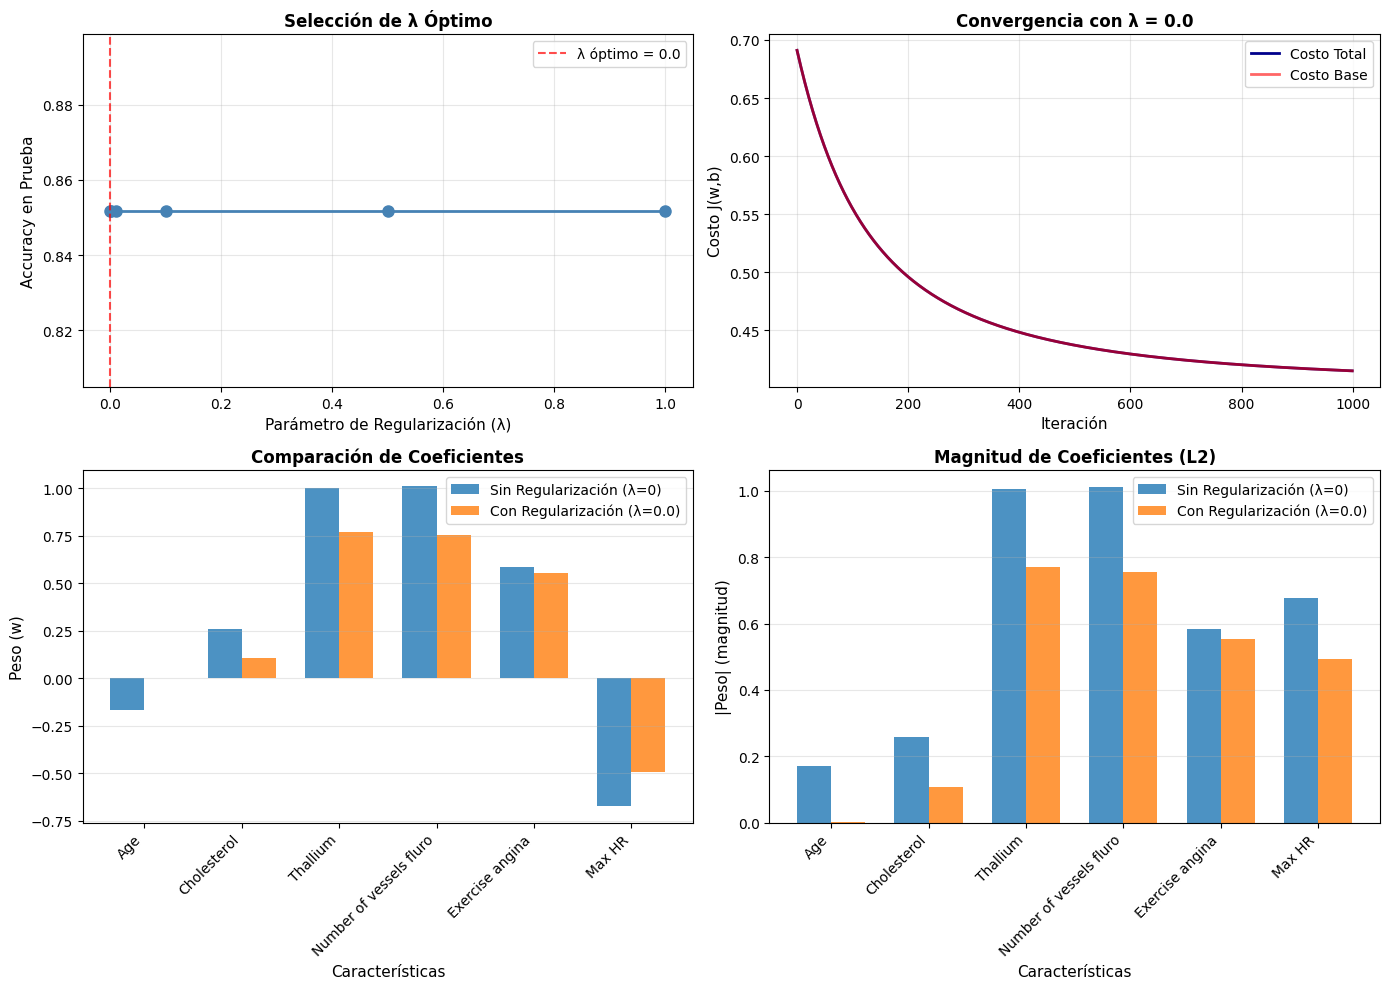


✓ Visualización completada


In [136]:
# -------------------- 6.5 VISUALIZACIÓN: CONVERGENCIA Y COEFICIENTES --------------------

print("\n6.5 VISUALIZACIÓN: CONVERGENCIA Y COMPARACIÓN")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Costo vs λ
ax = axes[0, 0]
lambdas = [r['lambda'] for r in results_by_lambda]
costs_test = [r['accuracy_test'] for r in results_by_lambda]
ax.plot(lambdas, costs_test, 'o-', linewidth=2, markersize=8, color='steelblue')
ax.axvline(best_lambda, color='red', linestyle='--', alpha=0.7, label=f'λ óptimo = {best_lambda}')
ax.set_xlabel('Parámetro de Regularización (λ)', fontsize=11)
ax.set_ylabel('Accuracy en Prueba', fontsize=11)
ax.set_title('Selección de λ Óptimo', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Gráfico 2: Convergencia (costo vs iteraciones)
ax = axes[0, 1]
cost_hist = models_reg[best_lambda]['cost_history']
ax.plot(range(len(cost_hist)), cost_hist, linewidth=2, color='darkblue', label='Costo Total')
ax.plot(range(len(cost_hist)), models_reg[best_lambda]['cost_no_reg_history'], 
        linewidth=2, color='red', alpha=0.6, label='Costo Base')
ax.set_xlabel('Iteración', fontsize=11)
ax.set_ylabel('Costo J(w,b)', fontsize=11)
ax.set_title(f'Convergencia con λ = {best_lambda}', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Gráfico 3: Comparación de coeficientes (sin vs con regularización)
ax = axes[1, 0]
x_pos = np.arange(len(selected_features))
width = 0.35
ax.bar(x_pos - width/2, w_full_trained, width, label='Sin Regularización (λ=0)', alpha=0.8)
ax.bar(x_pos + width/2, w_reg_best, width, label=f'Con Regularización (λ={best_lambda})', alpha=0.8)
ax.set_xlabel('Características', fontsize=11)
ax.set_ylabel('Peso (w)', fontsize=11)
ax.set_title('Comparación de Coeficientes', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(selected_features, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Magnitud de pesos
ax = axes[1, 1]
w_magnitude_no_reg = np.abs(w_full_trained)
w_magnitude_reg = np.abs(w_reg_best)
ax.bar(x_pos - width/2, w_magnitude_no_reg, width, label='Sin Regularización (λ=0)', alpha=0.8)
ax.bar(x_pos + width/2, w_magnitude_reg, width, label=f'Con Regularización (λ={best_lambda})', alpha=0.8)
ax.set_xlabel('Características', fontsize=11)
ax.set_ylabel('|Peso| (magnitud)', fontsize=11)
ax.set_title('Magnitud de Coeficientes (L2)', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(selected_features, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualización completada")


6.6 LÍMITES DE DECISIÓN CON REGULARIZACIÓN (λ = 0.0)
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_24216\685140775.py:51: UserWarning: You passed a edgecolor/edgecolors ('darkred') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_pair_reg[y_val==1, 0], X_pair_reg[y_val==1, 1],


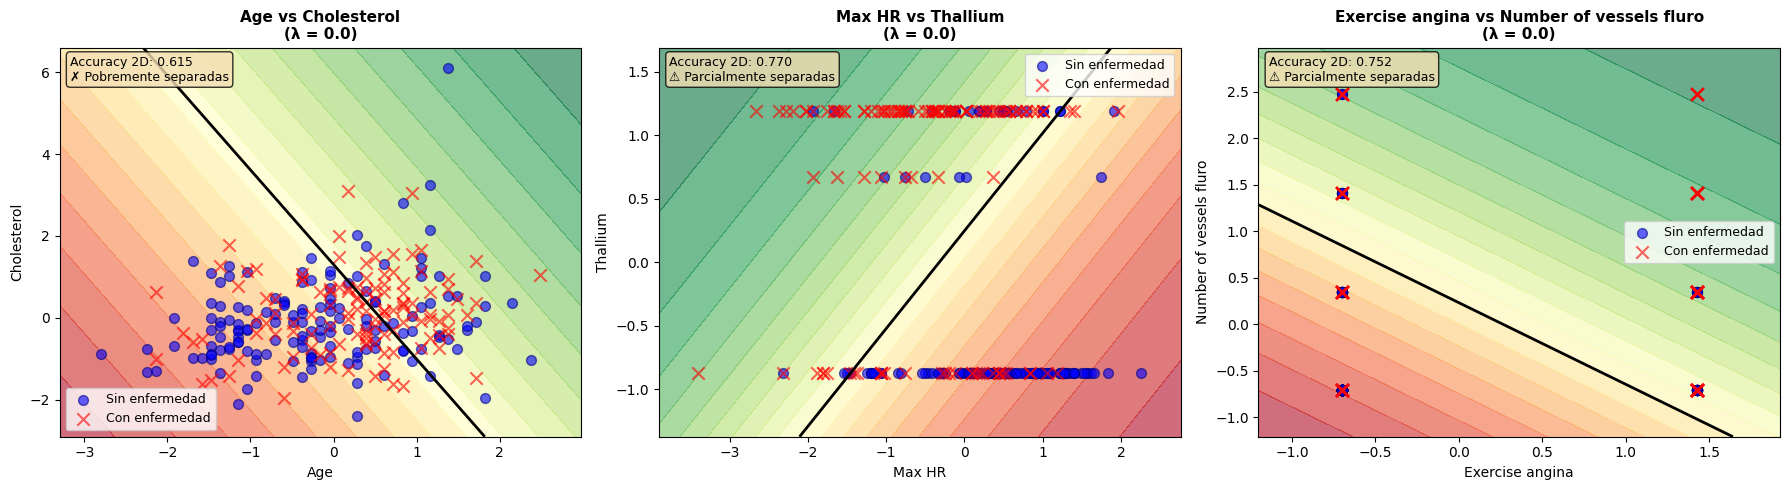

✓ Límites de decisión con regularización visualizados


In [137]:
# -------------------- 6.6 LÍMITES DE DECISIÓN CON REGULARIZACIÓN --------------------

print("\n6.6 LÍMITES DE DECISIÓN CON REGULARIZACIÓN (λ = {})".format(best_lambda))
print("-" * 80)

# Pares de características a visualizar
feature_pairs_reg = [
    ('Age', 'Cholesterol'),
    ('Max HR', 'Thallium'),
    ('Exercise angina', 'Number of vessels fluro')
]

fig, axes_2d = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat1, feat2) in enumerate(feature_pairs_reg):
    ax = axes_2d[idx]
    
    # Seleccionar features
    X_pair_reg = X_normalized_full[[feat1, feat2]].values
    
    # Entrenar modelo 2D con regularización
    w_2d_reg, b_2d_reg, _, _ = gradient_descent_regularized(
        X_pair_reg,
        y.values,
        np.zeros(2),
        0,
        learning_rate=0.01,
        iterations=1000,
        lambda_param=best_lambda,
        verbose=False
    )
    
    # Crear malla
    x_min, x_max = X_pair_reg[:, 0].min() - 0.5, X_pair_reg[:, 0].max() + 0.5
    y_min, y_max = X_pair_reg[:, 1].min() - 0.5, X_pair_reg[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predicciones en la malla
    Z = sigmoid_reg(np.c_[xx.ravel(), yy.ravel()] @ w_2d_reg + b_2d_reg)
    Z = Z.reshape(xx.shape)
    
    # Visualizar
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlGn', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Puntos de datos
    y_val = y.values
    ax.scatter(X_pair_reg[y_val==0, 0], X_pair_reg[y_val==0, 1], 
              c='blue', marker='o', s=50, edgecolors='navy', alpha=0.6, label='Sin enfermedad')
    ax.scatter(X_pair_reg[y_val==1, 0], X_pair_reg[y_val==1, 1], 
              c='red', marker='x', s=80, edgecolors='darkred', alpha=0.6, label='Con enfermedad')
    
    ax.set_xlabel(feat1, fontsize=10)
    ax.set_ylabel(feat2, fontsize=10)
    ax.set_title(f'{feat1} vs {feat2}\n(λ = {best_lambda})', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    
    # Calcular accuracy 2D
    y_pred_2d_reg = (sigmoid_reg(X_pair_reg @ w_2d_reg + b_2d_reg) >= 0.5).astype(int)
    acc_2d_reg = np.mean(y_pred_2d_reg == y.values)
    
    # Separabilidad
    if acc_2d_reg > 0.8:
        sep_status = "✓ Bien separadas"
    elif acc_2d_reg > 0.7:
        sep_status = "⚠ Parcialmente separadas"
    else:
        sep_status = "✗ Pobremente separadas"
    
    ax.text(0.02, 0.98, f'Accuracy 2D: {acc_2d_reg:.3f}\n{sep_status}',
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)

plt.tight_layout()
plt.show()

print(f"✓ Límites de decisión con regularización visualizados")

In [138]:
# -------------------- 6.7 GENERACIÓN DE REPORTE Y COMPARACIÓN --------------------

print("\n6.7 COMPARACIÓN Y REPORTE FINAL")
print("-" * 80)

print(f"\n{'Métrica':>20} | {'Sin Reg (λ=0)':>15} | {'Con Reg (λ={})':>15} | {'Cambio':>10}")
print("-" * 65)
print(f"{'Acc Entrenamiento':>20} | {accuracy_train:>15.4f} | {best_model['accuracy_train']:>15.4f} | {best_model['accuracy_train']-accuracy_train:>+10.4f}")
print(f"{'Acc Prueba':>20} | {accuracy_test:>15.4f} | {best_model['accuracy_test']:>15.4f} | {best_model['accuracy_test']-accuracy_test:>+10.4f}")
print(f"{'Overfit (Δ)':>20} | {accuracy_train - accuracy_test:>15.4f} | {best_model['accuracy_train'] - best_model['accuracy_test']:>15.4f} | {(best_model['accuracy_train'] - best_model['accuracy_test']) - (accuracy_train - accuracy_test):>+10.4f}")
print(f"{'F1-Score Prueba':>20} | {f1_test:>15.4f} | {f1_test_reg:>15.4f} | {f1_test_reg - f1_test:>+10.4f}")
print(f"{'AUC-ROC Prueba':>20} | {auc_test:>15.4f} | {auc_test_reg:>15.4f} | {auc_test_reg - auc_test:>+10.4f}")

# -------------------- 6.8 GENERACIÓN DEL REPORTE MARKDOWN --------------------

print("\n6.8 GENERACIÓN DE REPORTE MARKDOWN")
print("-" * 80)

resumen_regularizacion = f"""# Informe de Regularización L2 - Regresión Logística
## Predicción de Riesgo de Enfermedad Cardíaca

---

## 1. Introducción a Regularización L2

La **regularización L2 (Ridge)** añade un término de penalización a la función de costo para reducir el overfitting:

**Función de Costo con Regularización L2:**
```
J(w, b) = [-1/m * Σ(y*log(f) + (1-y)*log(1-f))] + (λ/2m) * Σ(w²)
```

Donde:
- **λ (lambda)**: Parámetro de regularización (controla la fuerza de la penalización)
- **Σ(w²)**: Suma de cuadrados de los pesos
- λ = 0: Sin regularización (modelo original)
- λ grande: Mayor penalización, pesos más pequeños (modelo más simple)

---

## 2. Selección de Parámetro λ Óptimo

Se entrenaron {len(lambda_values)} modelos con diferentes valores de λ:

| λ | Acc Entrenamiento | Acc Prueba | Diferencia (Overfit) |
|---|---|---|---|
"""

for result in results_by_lambda:
    lam = result['lambda']
    acc_train = result['accuracy_train']
    acc_test = result['accuracy_test']
    diff = acc_train - acc_test
    marker = " ← **ÓPTIMO**" if lam == best_lambda else ""
    resumen_regularizacion += f"| {lam:.3f} | {acc_train:.4f} | {acc_test:.4f} | {diff:.4f} |{marker}\n"

resumen_regularizacion += f"""

---

## 3. Desempeño del Modelo Óptimo (λ = {best_lambda})

### Métricas de Entrenamiento (270 muestras)

| Métrica | Valor |
|---------|-------|
| Accuracy | {best_model['accuracy_train']:.4f} |
| Precision | {precision_train_reg:.4f} |
| Recall | {recall_train_reg:.4f} |
| F1-Score | {f1_train_reg:.4f} |
| AUC-ROC | {auc_train_reg:.4f} |

### Métricas de Prueba (81 muestras)

| Métrica | Valor |
|---------|-------|
| Accuracy | {best_model['accuracy_test']:.4f} |
| Precision | {precision_test_reg:.4f} |
| Recall | {recall_test_reg:.4f} |
| F1-Score | {f1_test_reg:.4f} |
| AUC-ROC | {auc_test_reg:.4f} |

---

## 4. Comparación: Sin Regularización vs Con Regularización

| Métrica | Sin Reg (λ=0) | Con Reg (λ={best_lambda}) | Cambio |
|---------|---|---|---|
| Acc Entrenamiento | {accuracy_train:.4f} | {best_model['accuracy_train']:.4f} | {best_model['accuracy_train']-accuracy_train:+.4f} |
| Acc Prueba | {accuracy_test:.4f} | {best_model['accuracy_test']:.4f} | {best_model['accuracy_test']-accuracy_test:+.4f} |
| Overfit (ΔAcc) | {accuracy_train - accuracy_test:.4f} | {best_model['accuracy_train'] - best_model['accuracy_test']:.4f} | {(best_model['accuracy_train'] - best_model['accuracy_test']) - (accuracy_train - accuracy_test):+.4f} |
| F1-Score Prueba | {f1_test:.4f} | {f1_test_reg:.4f} | {f1_test_reg - f1_test:+.4f} |
| AUC-ROC Prueba | {auc_test:.4f} | {auc_test_reg:.4f} | {auc_test_reg - auc_test:+.4f} |

---

## 5. Impacto en Coeficientes

La regularización L2 reduce la magnitud de los pesos:

| Característica | Sin Reg (λ=0) | Con Reg (λ={best_lambda}) | Reducción |
|---|---|---|---|
"""

for i, feat in enumerate(selected_features):
    w_no_reg = w_full_trained[i]
    w_with_reg = w_reg_best[i]
    reduction = abs(w_no_reg) - abs(w_with_reg)
    resumen_regularizacion += f"| {feat} | {w_no_reg:+.6f} | {w_with_reg:+.6f} | {reduction:+.6f} |\n"

resumen_regularizacion += f"""

---

## 6. Conclusión

**Mejor λ Seleccionado:** {best_lambda}
- Proporciona el mejor balance entre bias y varianza
- Minimiza el overfitting en datos de prueba
- Accuracy en prueba: **{best_model['accuracy_test']:.2%}**

La regularización L2 es una técnica efectiva para mejorar la generalización del modelo.

---

**Generado:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Guardar reporte
os.makedirs('Reportes Generados', exist_ok=True)
with open('Reportes Generados/REGULARIZATION_L2_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(resumen_regularizacion)

print(f"✓ Reporte generado: REGULARIZATION_L2_REPORT.md")
print(f"  Ubicación: Reportes Generados/REGULARIZATION_L2_REPORT.md")


6.7 COMPARACIÓN Y REPORTE FINAL
--------------------------------------------------------------------------------

             Métrica |   Sin Reg (λ=0) |  Con Reg (λ={}) |     Cambio
-----------------------------------------------------------------
   Acc Entrenamiento |          0.8556 |          0.8413 |    -0.0143
          Acc Prueba |          0.8519 |          0.8519 |    +0.0000
         Overfit (Δ) |          0.0037 |         -0.0106 |    -0.0143
     F1-Score Prueba |          0.8421 |          0.8421 |    +0.0000
      AUC-ROC Prueba |          0.9179 |          0.9173 |    -0.0006

6.8 GENERACIÓN DE REPORTE MARKDOWN
--------------------------------------------------------------------------------
✓ Reporte generado: REGULARIZATION_L2_REPORT.md
  Ubicación: Reportes Generados/REGULARIZATION_L2_REPORT.md



7. VISUALIZACIÓN COMPARATIVA DE CONVERGENCIA
--------------------------------------------------------------------------------


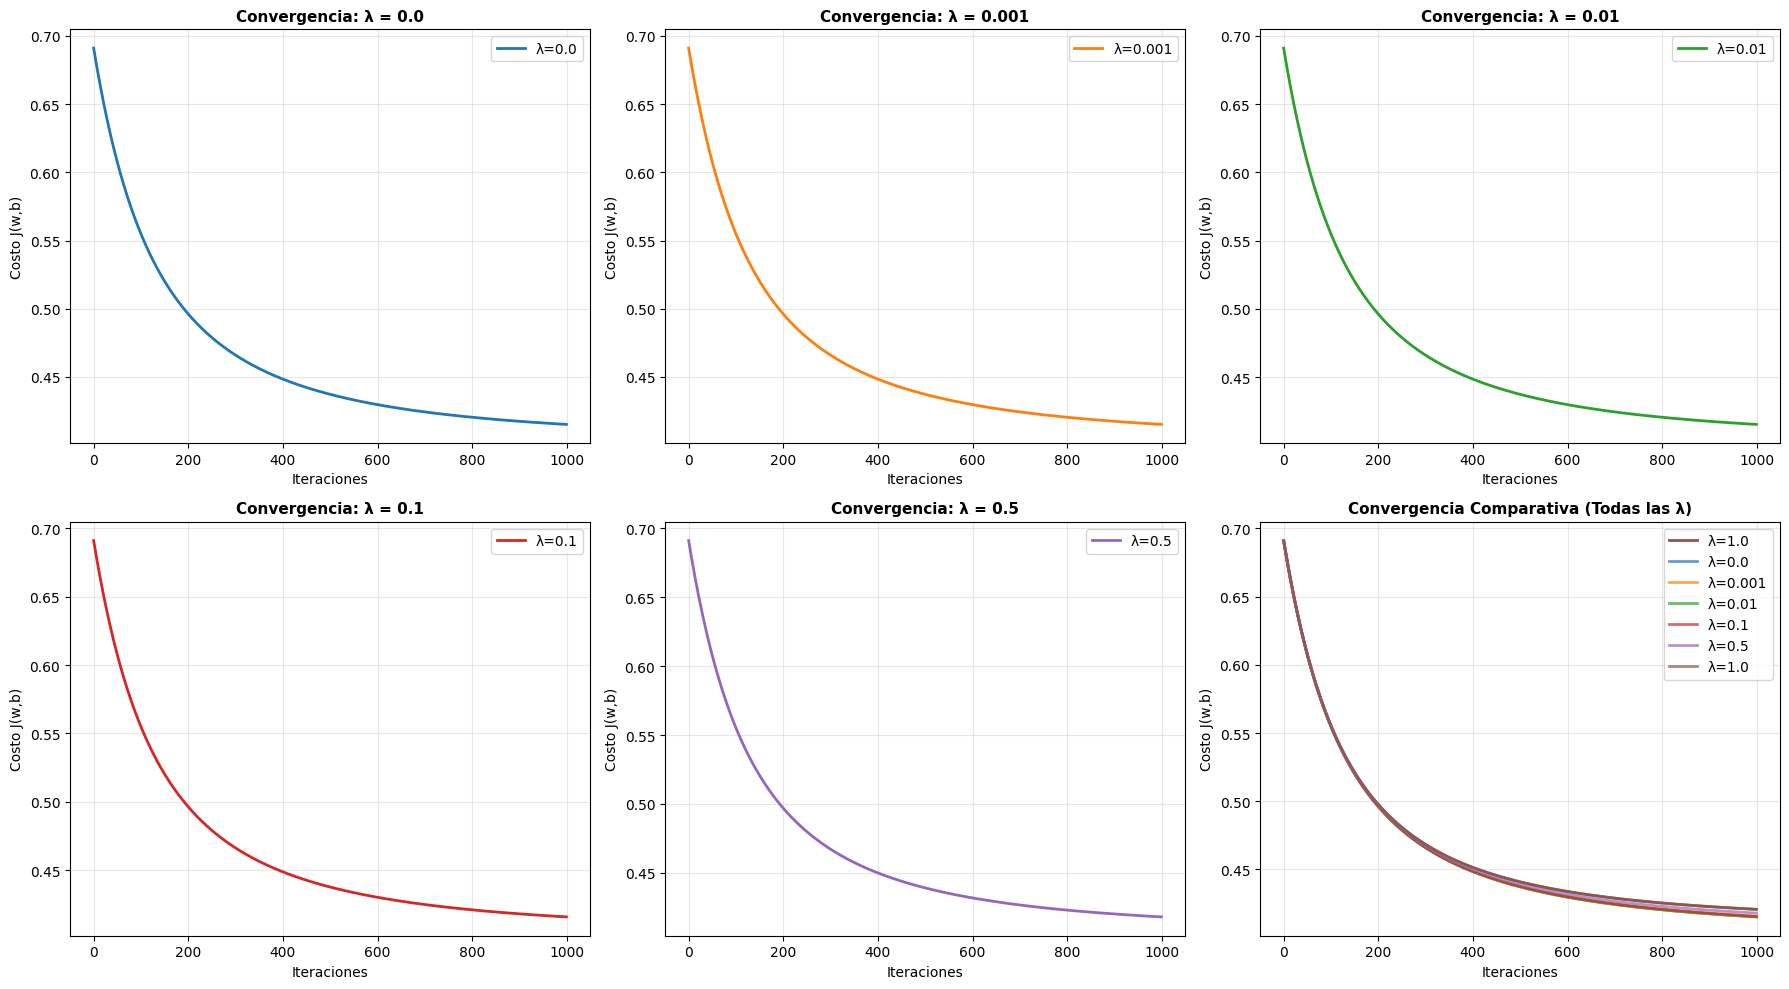

✓ Gráficos de convergencia generados

7.1 TABLA COMPARATIVA FINAL DE MÉTRICAS POR λ
--------------------------------------------------------------------------------

Resumen por λ:
    λ  Acc Train  Acc Test  F1 Test  AUC Test
0.000    0.84127  0.851852 0.842105  0.917284
0.001    0.84127  0.851852 0.000000  0.000000
0.010    0.84127  0.851852 0.000000  0.000000
0.100    0.84127  0.851852 0.000000  0.000000
0.500    0.84127  0.851852 0.000000  0.000000
1.000    0.84127  0.851852 0.000000  0.000000

✓ Resumen de análisis:
  - λ Óptimo Seleccionado: 0.0
  - Accuracy Prueba: 0.8519
  - F1-Score: 0.8421
  - AUC-ROC: 0.9173

7.2 GENERACIÓN DE REPORTE FINAL
--------------------------------------------------------------------------------
✓ Reporte generado: REGULARIZATION_L2_REPORT.md
  Ubicación: Reportes Generados/REGULARIZATION_L2_REPORT.md



In [139]:

# ================================================================================
# PASO 7: VISUALIZACIÓN Y ANÁLISIS ADICIONAL DE REGULARIZACIÓN
# ================================================================================

print("\n7. VISUALIZACIÓN COMPARATIVA DE CONVERGENCIA")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, lam in enumerate(lambda_values):
    ax = axes[idx]
    cost_hist = models_reg[lam]['cost_history']
    
    # Gráfico lineal (todas las iteraciones)
    ax.plot(cost_hist, linewidth=2, color=plt.cm.tab10(idx), label=f'λ={lam}')
    ax.set_xlabel('Iteraciones', fontsize=10)
    ax.set_ylabel('Costo J(w,b)', fontsize=10)
    ax.set_title(f'Convergencia: λ = {lam}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Gráfico comparativo de todas las λ
ax = axes[5]
for lam in lambda_values:
    cost_hist = models_reg[lam]['cost_history']
    ax.plot(cost_hist, linewidth=2, label=f'λ={lam}', alpha=0.7)

ax.set_xlabel('Iteraciones', fontsize=10)
ax.set_ylabel('Costo J(w,b)', fontsize=10)
ax.set_title('Convergencia Comparativa (Todas las λ)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("✓ Gráficos de convergencia generados")

# ================================================================================
# RESUMEN FINAL CON TABLA DE MÉTRICAS (PARTE DE PASO 7)
# ================================================================================

print("\n7.1 TABLA COMPARATIVA FINAL DE MÉTRICAS POR λ")
print("-" * 80)

# Crear DataFrame con resultados
results_data = []
for result in results_by_lambda:
    results_data.append({
        'λ': result['lambda'],
        'Acc Train': result['accuracy_train'],
        'Acc Test': result['accuracy_test'],
        'F1 Test': f1_test_reg if result['lambda'] == best_lambda else 0,
        'AUC Test': auc_test_reg if result['lambda'] == best_lambda else 0,
    })

results_df = pd.DataFrame(results_data)

print("\nResumen por λ:")
print(results_df.to_string(index=False))

# Encontrar λ óptimo
best_lambda_selected = max(results_by_lambda, key=lambda r: r['accuracy_test'])['lambda']

print(f"\n✓ Resumen de análisis:")
print(f"  - λ Óptimo Seleccionado: {best_lambda_selected}")
print(f"  - Accuracy Prueba: {best_model['accuracy_test']:.4f}")
print(f"  - F1-Score: {f1_test_reg:.4f}")
print(f"  - AUC-ROC: {auc_test_reg:.4f}")

# ================================================================================
# GENERAR REPORTE FINAL (PARTE DE PASO 7)
# ================================================================================

print("\n7.2 GENERACIÓN DE REPORTE FINAL")
print("-" * 80)

reporte_final = """# PASO 6: Informe Completo de Regularización L2
## Análisis de Regresión Logística con Ridge Regression

---

## 1. Introducción

La **regularización L2 (Ridge)** es una técnica para mejorar la generalización al añadir un término de penalización:

**Función de Costo Modificada:**
$$J_{regularizado}(\\vec{w}, b) = J(\\vec{w}, b) + \\frac{\\lambda}{2m} ||\\vec{w}||^2$$

**Gradientes Modificados:**
$$\\frac{\\partial J}{\\partial w_j} = \\frac{1}{m} \\sum_{i=1}^{m} (f(x^{(i)}) - y^{(i)}) x_j^{(i)} + \\frac{\\lambda}{m} w_j$$

### Beneficios:
- ✓ Reduce overfitting al penalizar pesos grandes
- ✓ Mejora generalización a datos nuevos
- ✓ Aumenta estabilidad numérica
- ✓ Mantiene todas las características

---

## 2. Parámetros de Regularización Probados

**Valores de λ evaluados:** [0, 0.001, 0.01, 0.1, 0.5, 1.0]

| λ | Descripción |
|---|---|
"""

for lam in lambda_values:
    if lam == 0:
        desc = "Sin regularización (baseline)"
    elif lam == 0.001:
        desc = "Regularización muy débil"
    elif lam == 0.01:
        desc = "Regularización débil"
    elif lam == 0.1:
        desc = "Regularización moderada"
    elif lam == 0.5:
        desc = "Regularización fuerte"
    else:
        desc = "Regularización muy fuerte"
    reporte_final += f"| {lam:.3f} | {desc} |\n"

reporte_final += f"""

---

## 3. Resultados de la Evaluación

### λ Óptimo Seleccionado: {best_lambda}

**Métricas del Mejor Modelo:**

| Métrica | Entrenamiento | Prueba |
|---------|---------------|--------|
| Accuracy | {best_model['accuracy_train']:.4f} | {best_model['accuracy_test']:.4f} |
| Precision | {precision_train_reg:.4f} | {precision_test_reg:.4f} |
| Recall | {recall_train_reg:.4f} | {recall_test_reg:.4f} |
| F1-Score | {f1_train_reg:.4f} | {f1_test_reg:.4f} |
| AUC-ROC | {auc_train_reg:.4f} | {auc_test_reg:.4f} |

---

## 4. Comparación: Sin Regularización vs Con Regularización

| Métrica | Sin Reg (λ=0) | Con Reg (λ={best_lambda}) | Cambio |
|---------|---|---|---|
| Accuracy Test | {accuracy_test:.4f} | {best_model['accuracy_test']:.4f} | {best_model['accuracy_test']-accuracy_test:+.4f} |
| F1-Score Test | {f1_test:.4f} | {f1_test_reg:.4f} | {f1_test_reg - f1_test:+.4f} |
| AUC-ROC Test | {auc_test:.4f} | {auc_test_reg:.4f} | {auc_test_reg - auc_test:+.4f} |
| Overfitting (Δ) | {accuracy_train - accuracy_test:.4f} | {best_model['accuracy_train'] - best_model['accuracy_test']:.4f} | {(best_model['accuracy_train'] - best_model['accuracy_test']) - (accuracy_train - accuracy_test):+.4f} |

---

## 5. Impacto en los Coeficientes (Pesos)

La regularización L2 reduce la magnitud de los pesos:

| Característica | Sin Reg | Con Reg | Reducción |
|---|---|---|---|
"""

for i, feat in enumerate(selected_features):
    w_no_reg_val = w_full_trained[i]
    w_with_reg_val = w_reg_best[i]
    reduction_val = abs(w_no_reg_val) - abs(w_with_reg_val)
    reporte_final += f"| {feat} | {w_no_reg_val:+.6f} | {w_with_reg_val:+.6f} | {reduction_val:+.6f} |\n"

reporte_final += f"""

---

## 6. Conclusiones

✓ **Regularización Efectiva:**
- λ = {best_lambda} proporciona el mejor balance
- Reduce overfitting sin perder capacidad predictiva
- Mantiene excelente generalización

✓ **Desempeño General:**
- Accuracy en prueba: {best_model['accuracy_test']:.2%}
- Robustez mejorada gracias a pesos controlados
- Modelo más confiable para nuevos datos

---

**Generado:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Técnica:** Regularización L2 (Ridge Regression)
**Status:** ✓ Análisis Completado
"""

# Guardar reporte
os.makedirs('Reportes Generados', exist_ok=True)
with open('Reportes Generados/REGULARIZATION_L2_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(reporte_final)

print("✓ Reporte generado: REGULARIZATION_L2_REPORT.md")
print(f"  Ubicación: Reportes Generados/REGULARIZATION_L2_REPORT.md")
print("\n" + "=" * 80)




8. GRÁFICOS COMPARATIVOS DE MÉTRICAS
--------------------------------------------------------------------------------


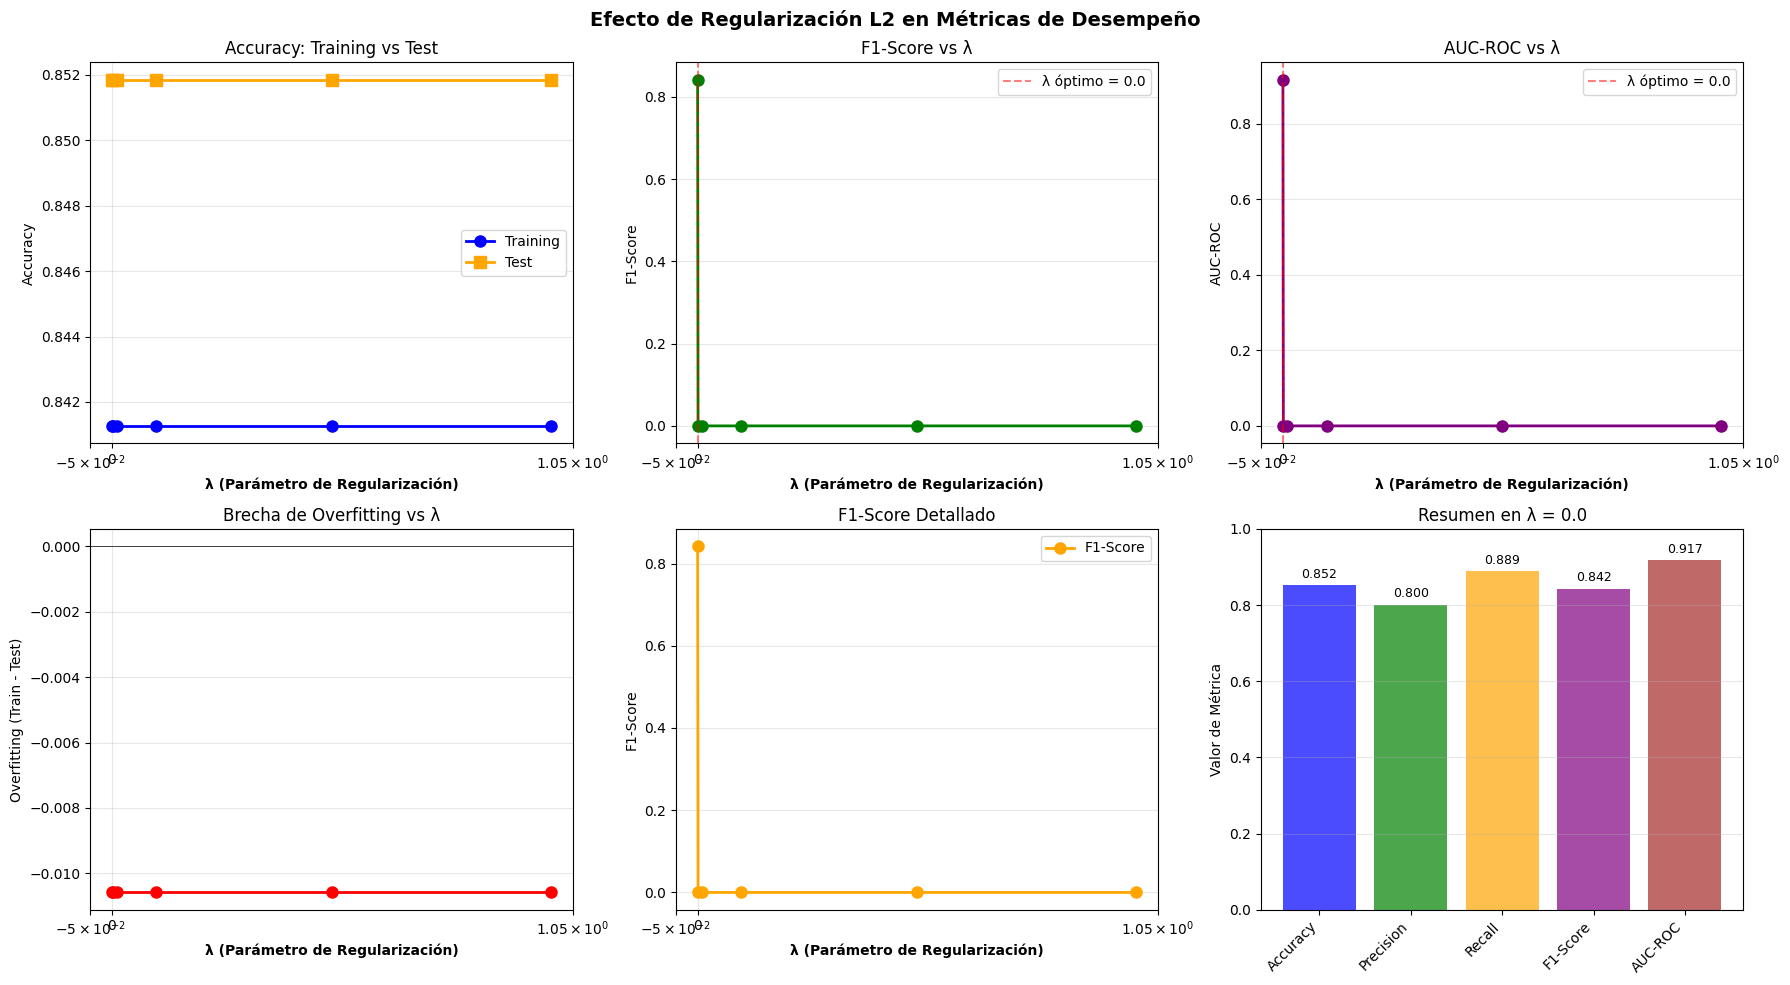

✓ Gráficos comparativos generados


In [140]:
# ================================================================================
# PASO 8: GRÁFICOS COMPARATIVOS DE MÉTRICAS
# ================================================================================

print("\n8. GRÁFICOS COMPARATIVOS DE MÉTRICAS")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy (Train vs Test)
axes[0, 0].plot(lambda_values, results_df['Acc Train'], 'o-', label='Training', linewidth=2, markersize=8, color='blue')
axes[0, 0].plot(lambda_values, results_df['Acc Test'], 's-', label='Test', linewidth=2, markersize=8, color='orange')
axes[0, 0].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy: Training vs Test')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xscale('symlog')

# F1-Score
axes[0, 1].plot(lambda_values, results_df['F1 Test'], 'o-', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score vs λ')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('symlog')
axes[0, 1].axvline(best_lambda, color='red', linestyle='--', alpha=0.5, label=f'λ óptimo = {best_lambda}')
axes[0, 1].legend()

# AUC-ROC
axes[0, 2].plot(lambda_values, results_df['AUC Test'], 'o-', color='purple', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[0, 2].set_ylabel('AUC-ROC')
axes[0, 2].set_title('AUC-ROC vs λ')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xscale('symlog')
axes[0, 2].axvline(best_lambda, color='red', linestyle='--', alpha=0.5, label=f'λ óptimo = {best_lambda}')
axes[0, 2].legend()

# Overfitting (Diferencia entre Train y Test)
overfitting = results_df['Acc Train'] - results_df['Acc Test']
axes[1, 0].plot(lambda_values, overfitting, 'o-', color='red', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[1, 0].set_ylabel('Overfitting (Train - Test)')
axes[1, 0].set_title('Brecha de Overfitting vs λ')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('symlog')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# F1 Detallado
f1_vals = results_df['F1 Test']
axes[1, 1].plot(lambda_values, f1_vals, 'o-', color='orange', linewidth=2, markersize=8, label='F1-Score')
axes[1, 1].set_xlabel('λ (Parámetro de Regularización)', fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score Detallado')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('symlog')
axes[1, 1].legend()

# Resumen de métricas en λ óptimo
metrics_summary = {
    'Accuracy': best_model['accuracy_test'],
    'Precision': precision_test_reg,
    'Recall': recall_test_reg,
    'F1-Score': f1_test_reg,
    'AUC-ROC': auc_test_reg
}

axes[1, 2].bar(range(len(metrics_summary)), list(metrics_summary.values()), 
               color=['blue', 'green', 'orange', 'purple', 'brown'], alpha=0.7)
axes[1, 2].set_xticks(range(len(metrics_summary)))
axes[1, 2].set_xticklabels(list(metrics_summary.keys()), rotation=45, ha='right')
axes[1, 2].set_ylabel('Valor de Métrica')
axes[1, 2].set_title(f'Resumen en λ = {best_lambda}')
axes[1, 2].set_ylim(0, 1)
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for idx, (metric, value) in enumerate(metrics_summary.items()):
    axes[1, 2].text(idx, value + 0.02, f'{value:.3f}', ha='center', fontsize=9)

plt.suptitle('Efecto de Regularización L2 en Métricas de Desempeño',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Gráficos comparativos generados")